# Install package

In [1]:
# install community
# library(devtools)

# devtools::install_github("SoloveyMaria/community")

# Calculate communication

In [2]:
# libraries
library(community)
library(ggplot2)
library(gridExtra)
library(grid)
library(ComplexHeatmap)
library(dendsort)
library(igraph)
require(circlize)
library(R.utils)
library(data.table) #to read gz file

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Loading required package: circlize

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github pa

In [3]:
getwd()

[1] "/work/project/ladcol_006/analysis/AMLniche/comparativeAnalysis/scripts_for_paper/community/src"

In [4]:
# the path to the counts, cell annotation and sample annation file. In this case its our working dir same as
# the notebook
path_in <- getwd()

print("path_in")
print(path_in)

[1] "path_in"
[1] "/work/project/ladcol_006/analysis/AMLniche/comparativeAnalysis/scripts_for_paper/community/src"


In [5]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/msolovey/miniconda3/envs/community_tutorial/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C                 LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] data.table_1.14.6     R.utils_2.12.2        R.oo_1.25.0          
 [4] R.methodsS3_1.8.2     circlize_0.4.15       igraph_1.3.5         
 [7] dendsort_0.3.4        ComplexHeatmap_2.14.0 gridExtra_2.3        
[10] ggplot2_3.4.0         community_1.2.2      

loaded via

## Load data

To calculate interactions, we will need the following files: normalized and batch corrected `counts`, cell annotation file `anno_cells`, and a sample annotation file `anno_samples`.

The `counts` file contains normalized and batch corrected counts with genes in the rows and cell IDs in the columns.

The `anno_cells` file should contain columns named cell_ID, cell_type and sample_ID.

The `anno_sample` file should countan columns named sample_ID health_status (e.g. "healthy" or "AML") and case_or_conrol (e.g. "control" or "case").

In [6]:
data("LR_database")
print(str(LR_database))

'data.frame':	7246 obs. of  25 variables:
 $ Pair.Name            : chr  "A2M_LRP1" "AANAT_MTNR1A" "AANAT_MTNR1B" "ABCA1_SHANK1" ...
 $ Ligand               : chr  "A2M" "AANAT" "AANAT" "ABCA1" ...
 $ Ligand.Name          : chr  "alpha-2-macroglobulin" "aralkylamine N-acetyltransferase" "aralkylamine N-acetyltransferase" "ATP binding cassette subfamily A member 1" ...
 $ Receptor             : chr  "LRP1" "MTNR1A" "MTNR1B" "SHANK1" ...
 $ Receptor.Name        : chr  "LDL receptor related protein 1" "melatonin receptor 1A" "melatonin receptor 1B" "SH3 and multiple ankyrin repeat domains 1" ...
 $ complex_pair         : chr  NA NA NA NA ...
 $ partner_a            : chr  "P01023" "Q16613" "Q16613" "O95477" ...
 $ partner_b            : chr  "Q07954" "P48039" "P49286" "Q9Y566" ...
 $ source               : chr  "P01023" "Q16613" "Q16613" "O95477" ...
 $ target               : chr  "Q07954" "P48039" "P49286" "Q9Y566" ...
 $ source_genesymbol    : chr  "A2M" "AANAT" "AANAT" "ABCA1" ...
 $ t

In [7]:
# # load counts
print("load counts")
counts <- fread("counts_corr.csv.gz", header = TRUE)
counts <- as.data.frame(counts)
rownames(counts) <- counts$gene_symbol
counts <- counts[,-1]
print(str(counts))

[1] "load counts"
'data.frame':	12485 obs. of  74583 variables:
 $ AML1012-D0_AAAAAGTTACGT: num  0.03236 0.00341 0.0019 -0.00154 0.00565 ...
 $ AML1012-D0_AAAACACCAATC: num  0.0632 0.00367 0.00606 0.00265 0.02014 ...
 $ AML1012-D0_AAAATAGCCTTT: num  0.01192 0.00545 0.0072 -0.00149 0.01288 ...
 $ AML1012-D0_AAACATTAAACG: num  0.14074 0.01313 0.00681 -0.00167 0.01139 ...
 $ AML1012-D0_AAACCACGTGCN: num  0.08601 0.001354 -0.000301 0.004807 0.008856 ...
 $ AML1012-D0_AAACGCTGGAAN: num  0.07267 0.00209 0.00378 0.00264 0.01749 ...
 $ AML1012-D0_AAACTGGTACTA: num  0.04825 0.00698 0.00129 0.00441 0.00424 ...
 $ AML1012-D0_AAACTTGCCCGT: num  0.10351 0.00211 0.00481 0.00484 0.02307 ...
 $ AML1012-D0_AAATGAAAGTCC: num  0.04366 0.00309 0.00707 0.00484 0.01954 ...
 $ AML1012-D0_AAATGTACGGTA: num  0.0386 0.00311 0.00279 0.00813 0.01409 ...
 $ AML1012-D0_AACAATGGTGTG: num  0.0826 0.00185 0.00968 0.00311 0.01459 ...
 $ AML1012-D0_AACATTTAACAT: num  0.05401 0.00276 0.00549 0.00416 0.0135 ...
 $ AML1012

In [8]:
# load cell annotation
print("load cell annotation")
anno_cells <- read.table(paste0(path_in,"/anno_cells_corr.txt")
                         ,sep = "\t"
                         ,row.names = 1
                         ,header = TRUE
                         )
print(str(anno_cells))

[1] "load cell annotation"
'data.frame':	74583 obs. of  37 variables:
 $ cell_ID.1                     : chr  "AML1012-D0_AAAAAGTTACGT" "AML1012-D0_AAAACACCAATC" "AML1012-D0_AAAATAGCCTTT" "AML1012-D0_AAACATTAAACG" ...
 $ cell_type_original            : chr  "GMP" "GMP-like" "Prog-like" "ProMono-like" ...
 $ sample_ID                     : chr  "AML1012-D0" "AML1012-D0" "AML1012-D0" "AML1012-D0" ...
 $ malignant                     : chr  "False" "True" "True" "True" ...
 $ patient_ID                    : chr  "AML1012" "AML1012" "AML1012" "AML1012" ...
 $ dataset                       : chr  "GSE116256" "GSE116256" "GSE116256" "GSE116256" ...
 $ gender                        : chr  "F" "F" "F" "F" ...
 $ age                           : int  32 32 32 32 32 32 32 32 32 32 ...
 $ health_status                 : chr  "AML" "AML" "AML" "AML" ...
 $ case_or_control               : chr  "case" "case" "case" "case" ...
 $ day                           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ cell_typ

In [9]:
# load sample annotation
print("load sample annotation")
anno_samples <- read.table(paste0(path_in,"/anno_samples_corr.txt")
                           ,sep = "\t"
                           ,row.names = 1
                           ,header = TRUE
                           )
print(str(anno_samples))

[1] "load sample annotation"
'data.frame':	33 obs. of  15 variables:
 $ sample_ID                    : chr  "AML1012-D0" "AML210A-D0" "AML328-D0" "AML419A-D0" ...
 $ patient_ID                   : chr  "AML1012" "AML210A" "AML328" "AML419A" ...
 $ dataset                      : chr  "GSE116256" "GSE116256" "GSE116256" "GSE116256" ...
 $ gender                       : chr  "F" "M" "F" "F" ...
 $ age                          : int  32 67 74 54 58 70 26 57 42 52 ...
 $ health_status                : chr  "AML" "AML" "AML" "AML" ...
 $ case_or_control              : chr  "case" "case" "case" "case" ...
 $ day                          : num  0 0 0 0 0 0 0 0 0 NA ...
 $ nr_cells_raw                 : int  1136 748 1094 1189 485 2328 1586 933 3813 108 ...
 $ nr_cells_cf                  : int  951 640 965 1091 399 2196 1410 869 3574 93 ...
 $ nr_cells_cf_ctf              : int  946 603 909 1086 388 2186 1407 868 3504 93 ...
 $ total_counts_raw_cf_ctf_gf   : int  2060373 1530216 2367765 278338

The ligand-receptor pair database is provided by the algorithm, but the user can also use a custom database. In this case, the custom database should have the columns named 'Ligand', 'Receptor' and 'Pair.Name'. 

## Thresholds

When calculation the interactions, it is possible to set three threshold: 
- `threshold_celltype_size` is a threshold for the minimum number of cells that a cell type should contain (in one sample). If the number of cells in the cell type of interest in a particular sample is less or equal to the `threshold_celltype_size`, then we consider this cell type as missing in this sample. This threshold affects the relative cell type abundance parameter (rho). The deafult value for the `threshold_celltype_size` is 4. 
- `threshold_nr_active_cells` is a threshold for the minimum number of active cells in a cell type (in the sample of interest). A cell is concidered as active (for a specific gene), if it is expressing this gene above the `threshold_expr`. If the number of active cells (for a specific gene) in a cell type is smaller or equal to the `threshold_nr_active_cells`, i.e. does not pass the threshold, then it is set to zero (in this sample). This threshold affects the relative active fraction (phi) parameter. The deafult value for the `threshold_expr` is zero.
- `threshold_expr` is a threshold for an expression value of a gene in a cell. If an expression value af a gene in a cell is smaller or equal to the `threshold_expr` value, it will be set to zero. This threshold affects the relative active fration (phi) and the relative mean expression (p) paramteres. The deafult value for the `threshold_expr` is zero. In our analysis, we will though set it arbtrarily to 0.05.

In [10]:
# set threshold of the cell type size
threshold_celltype_size <- 6
print("threshold_celltype_size >")
print(threshold_celltype_size)

[1] "threshold_celltype_size >"
[1] 6


In [11]:
# set threshold of the minimum number of active cells
threshold_nr_active_cells <- 6
print("threshold_nr_active_cells >")
print(threshold_nr_active_cells)

[1] "threshold_nr_active_cells >"
[1] 6


In [12]:
# set threshold of expression
threshold_expr <- 0.1
print("threshold_expr >")
print(threshold_expr)

[1] "threshold_expr >"
[1] 0.1


## Calculate interactions

In [13]:
# Renaming the first column in anno_cells to "cell_ID"
colnames(anno_cells)[1] <- "cell_ID"

In [15]:
print("calculate communication")
interactions = calculate_communication(counts = counts
                                       ,anno_samples = anno_samples
                                       ,anno_cells = anno_cells
                                       ,threshold_celltype_size = threshold_celltype_size
                                       ,threshold_nr_active_cells = threshold_nr_active_cells
                                       ,threshold_expr = threshold_expr
                                       ,lrp_database = LR_database
                                       )

# print(str(interactions))


[1] "calculate communication"


ERROR: Error in sapply(strsplit(dummy_anno_interactions$interaction_ID, "_"), : incorrect number of dimensions


## Calculate general statistics

The `general_stat` function calculates for each interaction several parameters that will be used for the QC, visualization and the differential communication analysis. 

Following parameters for the QC step will be stored in the `anno_interactions` list:
- mean expression of a ligand in the active fraction of the sending cell type within the control cohort (`mean_e_s_l_control`) and within the case cohort (`mean_e_s_l_case`). 
- mean  expression of a receptor in the active fraction of the receiving cell type within the control cohort (`mean_e_r_r_control`) and within the case cohort (`mean_e_r_r_case`).

Following parameters for the visulisation will be stored in the `anno_interactions` list:
- log2 fold change of `rho_s` between the cases and the controls (`log2FC_rho_s`). It shows for each interaction, how the cell type abundance of the sending cell type changed in the cases compared to the controls.
- log2 fold change of `rho_r` between the cases and the controls (`log2FC_rho_r_r`). It shows for each interaction, how the cell type abundance of the receiving cell type changed in the cases compared to the controls.
- log2 fold change of `rho` between the cases and the controls (`log2FC_rho`). It shows for each interaction, how the whole `rho` parameter changed in the cases compared to the controls.
- log2 fold change of `phi_l_s` between the cases and the controls (`log2FC_phi_l_s`). It shows for each interaction, how the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `phi_r_r` between the cases and the controls (`log2FC_phi_r_r`). It shows for each interaction, how the active fraction of the receptors in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `phi` between the cases and the controls (`log2FC_phi`). It shows for each interaction, how the whole `phi` parameter changed in the cases compared to the controls.
- log2 fold change of `p_l_s` between the cases and the controls (`log2FC_p_l_s`). It shows for each interaction, how the mean expression whithin the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `p_r_r` between the cases and the controls (`log2FC_p_r_r`). It shows for each interaction, how the mean expression whithin the active fraction of the receptor in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `p` between the cases and the controls (`log2FC_p`). It shows for each interaction, how the whole `p` parameter changed in the cases compared to the controls.

Following parameter for the differential communication analysis will be stored in the `anno_interactions` list:
- log2 fold change of `weights` between the cases and the controls (`log2FC_weights`). It shows for each interaction, how the whole interaction weight changed in the cases compared to the controls.


In [13]:
print("calculate general statistics")

interactions <- general_stat(comm_result = interactions
                                   ,verbose = FALSE#TRUE
)
print(str(interactions$anno_interactions))

[1] "calculate general statistics"
'data.frame':	24408 obs. of  19 variables:
 $ interaction_ID     : chr  "HSPC:ADAM10_HSPC:AXL" "HSPC:ADAM15_HSPC:ITGA5" "HSPC:ADAM15_HSPC:ITGA9" "HSPC:ADAM15_HSPC:ITGAV" ...
 $ ligand_gene_name   : chr  "ADAM10" "ADAM15" "ADAM15" "ADAM15" ...
 $ receptor_gene_name : chr  "AXL" "ITGA5" "ITGA9" "ITGAV" ...
 $ sending_cell_type  : chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ receiving_cell_type: chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ mean_e_s_l_control : num  0.1731 0.0429 0.0429 0.0429 0.0429 ...
 $ mean_e_s_l_case    : num  0.2069 0.0521 0.0521 0.0521 0.0521 ...
 $ mean_e_r_r_control : num  0.00217 0.07017 0.04075 0.02452 0.32592 ...
 $ mean_e_r_r_case    : num  0 0.0815 0.035 0.0327 0.3652 ...
 $ log2FC_rho_s       : num  3.22 3.22 3.22 3.22 3.22 ...
 $ log2FC_rho_r       : num  3.22 3.22 3.22 3.22 3.22 ...
 $ log2FC_rho         : num  5.73 5.73 5.73 5.73 5.73 ...
 $ log2FC_phi_s_l     : num  -0.00108 0.2852 0.2852 0.2852 0.2852 ...
 $ log2FC_phi_r_r     

# QC

For the quality check, we use three filters: the **interaction weight filter**, the **presense per cohort filter** and the **ligand/receptor expression filter**. An interaction is considered of good quality, if it passes all three filters.

The **interaction weight filter** checks the log10 cumulative weight of the interaction. To pass this filter, the interaction need to be greater than the `threshold_log10_cum_weight` threshold.

In [6]:
threshold_log10_cum_weight <-  0.01
print("threshold_log10_cum_weight >")
print(threshold_log10_cum_weight)

[1] "threshold_log10_cum_weight >"
[1] 0.01


The **presense per cohort filter** checks the fraction of samples in which an interaction was detected (i.e. has a non-zero value) in the control cohort and in the case cohort. To pass this filter, an interaction needs to has a greater value than the `threshold_frac_samples_per_condition` threshold either in the control cohort or in the case cohort or in both.

In [7]:
threshold_frac_samples_per_condition <-  0.6
print("threshold_frac_samples_per_condition >")
print(threshold_frac_samples_per_condition)

[1] "threshold_frac_samples_per_condition >"
[1] 0.6


The **ligand/receptor expression filter** checks the mean expression level of the ligand and the receptor of an interaction in the case and the control samples (separately). This filters uses a `threshold_log10meanexpr_per_condition` threshold.
For each einteraction four values are checked:
- log10 mean expression of the ligand in sending cells in control samples
- log10 mean expression of the receptor in receiving cells in control samples
- log10 mean expression of the ligand in sending cells in case samples
- log10 mean expression of the receptor in receiving ccells in case samples.


An interaction passes this filter if both its ligand and receptor pass the threshold either in control samples or in case samples or in both.

In [8]:
threshold_log10_meanexpr_per_condition <- 0.01
print("threshold_log10_meanexpr_per_condition >")
print(threshold_log10_meanexpr_per_condition)

[1] "threshold_log10_meanexpr_per_condition >"
[1] 0.01


A good quality interaction should pass all filters.

The `filter_interactions` function produces one plot for the **interaction weight filter**, two plots for the **presense per cohort filter** (one for the controls and one for the cases) and two plots for the **ligand/receptor expression filter** (one for the controls and one for the cases). It writes the selected threshold values in the `thresholds` list of the interaction object and stores the filtering results as boolean vectors (one per threshold) in the `anno_interactions` list. The function does not subset the data, so if you want to change the filtering parameters, you can re-define the thresholds and re-run the `filter_interactions` function.

In [9]:
# REMOVE THIS!!!!
load(paste0(path_in
           ,"/interactions_old.RData"))


In [10]:
# REMOVE THIS
#' @title filter_interactions
#'
#' @description The `filter_interactions` function produces one plot for the **quality filter** and two plots for the **discrepancy filter** (one for the controls and one for the cases). It writes the selected threshold values in the `thresholds` list of the interaction object and stores the filtering results as boolean vectors (one per threshold) in the `anno_interactions` list.
#' 
#' @param comm_result: list containing information about the interactions, samples, and their annotations.
#' @param threshold_log10_cum_weight numeric: the threshold for the log10 cumulative weight of interactions. The default value is 0.05.
#' @param threshold_frac_samples_per_condition numeric: the threshold for the fraction of samples in which an interaction has a non-zero value. The threshold is applied separately for controls and the cases. An interaction passes the filter if it passes this threshold either for the control samples, or for the case samples, or for both. The default value is 0.8.
#' @param threshold_log10_meanexpr_per_condition numeric: the threshold for the log10 mean expression per condition. The default value is 0.01.
#' @param verbose a logical value indicating whether to print progress messages (default: FALSE).
#'
#' @return comm_results: The dataframe anno_interactions gets following new columns: 
#' - anno_interactions
#' -- log10_cum_weight: numeric: the log10 cumulative weight of an interaction
#' -- frac_samples_controls: numeric: the fraction of control samples in which an interaction has a non-zero value
#' -- frac_samples_cases: numeric: the fraction of case samples in which an interaction has a non-zero value
#' -- passed_log10_cum_weight_filter: a logical value indicating whether an interaction passed the log10_cum_weight filter
#' -- passed_frac_samples_filter: a logical value indicating whether an interaction passed the frac_samples filter
#' -- passed_log10_meanexpr_control_filter: a logical value indicating whether an interaction passed the threshold_log10_meanexpr_per_condition filter in the control samples
#' -- passed_log10_meanexpr_case_filter: a logical value indicating whether an interaction passed the threshold_log10_meanexpr_per_condition filter in the case samples
#' -- passed_log10_meanexpr_per_condition_filter: a logical value indicating whether an interaction passed the threshold_log10_meanexpr_per_condition filter. An interaction passes this filter if both its ligand and receptor pass the threshold either in control samples or in case samples or in both.
#' -- passed_QC_filter: a logical value indicating whether an interaction passed all the QC filters.
#' 
#' - thresholds
#' -- threshold_log10_cum_weight: numeric: the threshold for the log10 cumulative weight of interactions. The default value is 0.05.
#' -- threshold_frac_samples_per_condition: numeric: the threshold for the fraction of samples in which an interaction has a non-zero value. The threshold os applied separately for controls and the cases. The default value is 0.8.
#' -- threshold_log10_meanexpr_per_condition: numeric: the threshold for the log10 mean expression per condition. The default value is 0.01.
#'   
#' @export

filter_interactions <- function(comm_result, threshold_log10_cum_weight = 0.05, threshold_frac_samples_per_condition = 0.8,
                                threshold_log10_meanexpr_per_condition = 0.1, verbose = TRUE) {
        # plot the distribution of log10 cumulative interactions weight over the
        # fraction of samples in which the interactions is expressed
        
        # calculate log10 cumulative interactions weights
        comm_result$anno_interactions$log10_cum_weight <- log10(rowSums(comm_result$weights) + 1)
        
        # identify control samples
        idx_control <- comm_result$anno_samples$case_or_control == "control"
        idx_case <- comm_result$anno_samples$case_or_control == "case"
        
        # calculate the fraction of samples expressing the interactions
        comm_result$anno_interactions$frac_samples_controls <- rowSums(comm_result$weights[,idx_control] != 0) / sum(idx_control) 
        comm_result$anno_interactions$frac_samples_cases <- rowSums(comm_result$weights[,idx_case] != 0) / sum(idx_case) 
        
        # set thresholds
        comm_result$thresholds$threshold_log10_cum_weight <- threshold_log10_cum_weight
        comm_result$thresholds$threshold_frac_samples_per_condition = threshold_frac_samples_per_condition
        comm_result$thresholds$threshold_log10_meanexpr_per_condition = threshold_log10_meanexpr_per_condition
        
        
        cumW <- plot_cumW(df = comm_result$anno_interactions, threshold_log10_cum_weight = threshold_log10_cum_weight)
        fracSamp <- plot_fracSamples(df = comm_result$anno_interactions, threshold_frac_samples_per_condition = threshold_frac_samples_per_condition)
        
        p <- arrangeGrob(fracSamp$ydensity
                                     ,fracSamp$QC_plot
                                     ,fracSamp$blankPlot
                                     ,fracSamp$xdensity
                                     ,ncol=2
                                     ,nrow=2
                                     ,widths=c(2.5, 5.5)
                                     ,heights=c(6.5, 1.5)
                        )
    
        # arrange plots
        grid.arrange(cumW
                     , p
                     , ncol=2
                     , widths = c(3.5,4.5)
                    )
        
        plot_meanLig_vs_meanRec(comm_result$anno_interactions, threshold_log10_meanexpr_per_condition = threshold_log10_meanexpr_per_condition)
        
        # filter interactions which did not pass the threshold in any sample
        comm_result$anno_interactions$passed_log10_cum_weight_filter <- comm_result$anno_interactions$log10_cum_weight >
                threshold_log10_cum_weight
        comm_result$anno_interactions$passed_frac_samples_filter <- (comm_result$anno_interactions$frac_samples_controls >
                                                                                  threshold_frac_samples_per_condition) | (comm_result$anno_interactions$frac_samples_cases > threshold_frac_samples_per_condition)
        comm_result$anno_interactions$passed_log10_meanexpr_control_filter <- (log10(comm_result$anno_interactions$mean_e_s_l_control +
                                                                                   1) > threshold_log10_meanexpr_per_condition) & (log10(comm_result$anno_interactions$mean_e_r_r_control +
                                                                                                                                                 1) > threshold_log10_meanexpr_per_condition)
        
        
        comm_result$anno_interactions$passed_log10_meanexpr_case_filter <- (log10(comm_result$anno_interactions$mean_e_s_l_case +
                                                                                1) > threshold_log10_meanexpr_per_condition) & (log10(comm_result$anno_interactions$mean_e_r_r_case +
                                                                                                                                              1) > threshold_log10_meanexpr_per_condition)
        
        comm_result$anno_interactions$passed_log10_meanexpr_per_condition_filter <- comm_result$anno_interactions$passed_log10_meanexpr_control_filter |
                comm_result$anno_interactions$passed_log10_meanexpr_case_filter
        
        # filter anno_interactions
        comm_result$anno_interactions$passed_QC_filter <- (comm_result$anno_interactions$passed_log10_cum_weight_filter &
                                                                   comm_result$anno_interactions$passed_frac_samples_filter & comm_result$anno_interactions$passed_log10_meanexpr_per_condition_filter)
        
        samples <- names(comm_result$per_sample_anno_interactions)
        
        if (verbose) {
                print(paste(sum(!(comm_result$anno_interactions$passed_log10_cum_weight_filter & comm_result$anno_interactions$passed_frac_samples_filter)),
                            "out of", nrow(comm_result$weights), "interactions do not pass the thresholds for log10 cumulative interactions weight >",
                            threshold_log10_cum_weight, "and fraction of expressing samples >", threshold_frac_samples_per_condition,
                            ". Also ", sum(!comm_result$anno_interactions$passed_log10_meanexpr_per_condition_filter),
                            " interactions didn't pass the discrepancy filter.", " In total,", sum(!comm_result$anno_interactions$passed_QC_filter),
                            " bad quality interactions will be removed and", sum(comm_result$anno_interactions$passed_QC_filter),
                            "good quality interactions will remain."))
        }
        
        return(comm_result)
}

In [11]:
# REMOVE THIS!!!!
#' @title plot_fracSamples
#'
#' @description creates a scatter plot of fraction of samples in which the interactions are expressed. It also gives a visual representation of whether the interactions passed a certain threshold for log10 cumulative weight and number of samples expressed in.
#'
#' @param df: dataframe: dataframe containing the interactions, including columns "frac_samples_controls" and "frac_samples_cases"
#' @param threshold_frac_samples_per_condition: numeric: threshold for the fraction of samples in which the interactions are detected. 
#'
#' @return scatter plot, x axis is fraction of samples in controls, y axis is fraction of samples in cases
#'
#' @export
#' @examples
#' # plot the fraction of samples in which the interactions are detected
#' plot_fracSamples(df = anno_interactions_allSamples[[1]]
#'                       ,threshold_frac_samples_per_condition = 0.8
#' )
####### is this returning a list of ggplots?? because it's not clear from the code below


plot_fracSamples <- function(df,threshold_frac_samples_per_condition,...){
        # check which interactions passed the threshold
        df$passed_threshold <- (df$frac_samples_controls > threshold_frac_samples_per_condition) | (df$frac_samples_cases > threshold_frac_samples_per_condition)
        
        # main plot
        QC_plot <- ggplot(data = df
                          ,aes(x = frac_samples_controls
                               ,y = frac_samples_cases
                               ,color = passed_threshold
                               ,shape = passed_threshold
                          )
        )+
                
                geom_jitter(shape = 1
                            ,width = 0.01
                            ,height = 0.01)+
                scale_color_manual(labels = c("FALSE"="failed both\n thresholds"
                                              , "TRUE"="passed at least\none threshold")
                                   ,values=c("FALSE"="gray80"
                                             ,"TRUE"="black")
                                   ,guide = guide_legend()
                )+
                ggtitle("fraction of samples in which\nan interaction is detected")+
                xlab("controls")+
                ylab("cases")+
                geom_vline(xintercept = threshold_frac_samples_per_condition
                           , color = "red")+
                geom_hline(yintercept = threshold_frac_samples_per_condition
                           , color = "red")+
                theme_bw()+
                theme(text = element_text(size=20)
                      ,legend.position="bottom"
                      ,legend.title=element_blank())
        
        
        # x density plot
        xdensity <- ggplot(data = df
                           ,aes(x = frac_samples_controls))+
                geom_density()+
                geom_vline(xintercept = threshold_frac_samples_per_condition
                           , color = "red")+
                theme(text = element_text(size=0))+
                ggtitle("")+
                xlab("")+
                theme_bw()+
                theme(plot.margin = unit(c(0, 0, 1.8, 0), "cm"))
        
        # y density plot
        ydensity <- ggplot(data = df
                           ,aes(x = frac_samples_cases)
        )+
                geom_density()+
                xlab("")+
                geom_vline(xintercept = threshold_frac_samples_per_condition
                           , color = "red")+
                theme(text = element_text(size=0))+
                ggtitle("")+
                coord_flip()+
                theme_bw()+
                theme(plot.margin = unit(c(0.5, 1, 2.5, 2), "cm"))
        
        # Create a blank placeholder plot :
        blankPlot <- ggplot(data = df
                            ,aes(x = frac_samples_controls
                                 ,y = frac_samples_cases
                            )
        )+
                geom_jitter(alpha=0) +
                theme(axis.line=element_blank()
                      ,plot.background = element_blank(), 
                      panel.grid.major = element_blank(),
                      panel.grid.minor = element_blank(), 
                      panel.border = element_blank(),
                      panel.background = element_blank(),
                      axis.title.x = element_blank(),
                      axis.title.y = element_blank(),
                      axis.text.x = element_blank(), 
                      axis.text.y = element_blank(),
                      axis.ticks = element_blank())
        
        # arrange plots
        list(QC_plot = QC_plot
             ,ydensity = ydensity
             ,xdensity = xdensity
             ,blankPlot = blankPlot
            )
}

In [12]:
# REMOVE THIS!!!!
#' @title plot_cumW
#'
#' @description creates a histogram plot of log10 cumulative weight of interactions.
#'
#' @param df: dataframe: dataframe containing the interactions, including a column "log10_cum_weight"
#' @param threshold_log10_cum_weight: numeric: threshold for log10 cumulative weight of interactions. Interactions with a log10 cumulative weight above this threshold will be considered as passing the threshold.
#'
#' @return histogram plot
#'
#' @export
#' @examples
#' # plot the cumulative weight of the interactions
#' plot_cumW(df = anno_interactions_allSamples[[1]], threshold_log10_cum_weight = 0)
#' 
####### is this returning a list of ggplots?? because it's not clear from the code below


plot_cumW <- function(df,threshold_log10_cum_weight){
        
        # check which interactions passed the threshold
        df$passed_threshold <- df$log10_cum_weight > threshold_log10_cum_weight
        
        # main plot
        ggplot(data = df
                          ,aes(x = log10_cum_weight)
        )+
                
                geom_density()+
                ggtitle("interaction weight filter")+
                geom_vline(xintercept = threshold_log10_cum_weight
                           , color = "red")+
                theme_bw()+
                theme(text = element_text(size=20)
                      ,legend.title=element_blank())
        
}

In [13]:
# REMOVE THIS!!!
#' @title plot_meanLig_vs_meanRec
#' 
#' @description auxillary function for interactions QC: plot log10 mean ligand expression vs log10 mean receptor expression (in controls and cases separately).
#' 
#' @param df the df contains following columns: interactions_ID, mean_e_s_l_control, mean_e_s_l_case, mean_e_r_r_control, mean_e_r_r_case.
#' @param threshold_log10_meanexpr_per_condition numeric: threshold for log10 mean expression per condition. The default values is 0.1.
#' 
#' @return plotting function
#' 
#' @export
#' @examples
#' plot_meanLig_vs_meanRec(df = x$anno_interactions
#'                        ,threshold_log10_meanexpr_per_condition = threshold_log10_meanexpr_per_condition)
#' 
plot_meanLig_vs_meanRec <- function(df,threshold_log10_meanexpr_per_condition = 0.1
){
        
        max_value <- log10(max(df[,c("mean_e_s_l_control"
                                     ,"mean_e_s_l_case"
                                     ,"mean_e_r_r_control"
                                     ,"mean_e_r_r_case")]
                               ,na.rm=TRUE)+1)
        
        df$passed_discrepancy_threshold_control <- (log10(df$mean_e_s_l_control+1) > threshold_log10_meanexpr_per_condition) & (
                log10(df$mean_e_r_r_control+1) > threshold_log10_meanexpr_per_condition)
        
        df$passed_discrepancy_threshold_case <- (log10(df$mean_e_s_l_case+1) > threshold_log10_meanexpr_per_condition) & (
                log10(df$mean_e_r_r_case+1) > threshold_log10_meanexpr_per_condition)
        
        df$passed_discrepancy_threshold <- df$passed_discrepancy_threshold_control | df$passed_discrepancy_threshold_case
        
        plot_list <- lapply(c("control"
                              ,"case")
                            ,function(condition){
                                    ifelse(condition == "control"
                                           ,{my_df <- data.frame(interaction_ID = df$interaction_ID
                                                                 ,mean_expr_s_l_active = df$mean_e_s_l_control
                                                                 ,mean_expr_r_r_active = df$mean_e_r_r_control
                                                                 ,passed_discrepancy_threshold = df$passed_discrepancy_threshold
                                           )
                                           }
                                           ,{my_df <- data.frame(interaction_ID = df$interaction_ID
                                                                 ,mean_expr_s_l_active = df$mean_e_s_l_case
                                                                 ,mean_expr_r_r_active = df$mean_e_r_r_case
                                                                 ,passed_discrepancy_threshold = df$passed_discrepancy_threshold
                                           )
                                           }
                                    )
                                    
                                    # y density plot
                                    ydensity <- ggplot(data = my_df
                                                       ,aes(x = log10(mean_expr_s_l_active+1))
                                    )+
                                            geom_density()+
                                            xlim(c(0,max_value))+
                                            xlab("")+
                                            geom_vline(xintercept = threshold_log10_meanexpr_per_condition
                                                       , color = "red")+
                                            theme(text = element_text(size=0))+
                                            ggtitle("")+
                                            coord_flip()+
                                            theme_bw()+
                                            theme(plot.margin = unit(c(0.5, 1, 2.5, 2), "cm"))
                                    
                                    # main plot
                                    QC_plot <- ggplot(data = my_df
                                                      ,aes(x = log10(mean_expr_r_r_active+1)
                                                           ,y = log10(mean_expr_s_l_active+1)
                                                           ,color = passed_discrepancy_threshold
                                                           ,shape = passed_discrepancy_threshold
                                                      )
                                    )+
                                            geom_point(alpha = 0.5
                                                       #,show.legend = FALSE
                                            )+
                                            scale_color_manual(labels = c("FALSE"="failed threshold in\nboth conditions"
                                                                          , "TRUE"="passed threshold in\nat least one condition")
                                                               ,values=c("FALSE"="gray80"
                                                                         ,"TRUE"="black")
                                                               ,guide = guide_legend()
                                            )+
                                            scale_shape_manual(labels = c("FALSE"="failed threshold in\nboth conditions"
                                                                          , "TRUE"="passed threshold in\nat least one condition")
                                                               ,values=c("FALSE"=16,"TRUE"=1)
                                                               ,guide = guide_legend()
                                            )+
                                            ggtitle(condition)+
                                            ylim(c(0,max_value))+
                                            xlim(c(0,max_value))+
                                            xlab("receptor in receiving cell type\n[log10 mean expression]")+
                                            ylab("ligand in sending cell type\n[log10 mean expression]")+
                                            geom_vline(xintercept = threshold_log10_meanexpr_per_condition
                                                       , color = "red")+
                                            geom_hline(yintercept = threshold_log10_meanexpr_per_condition
                                                       , color = "red")+
                                            theme_bw()+
                                            theme(text = element_text(size=20)
                                                  ,legend.position="bottom"
                                                  ,legend.title=element_blank()
                                            )
                                    #guides(color = guide_legend(label.position = "bottom")
                                    #       ,shape = guide_legend(label.position = "bottom")
                                    #      )+
                                    
                                    
                                    # x density plot
                                    xdensity <- ggplot(data = my_df
                                                       ,aes(x = log10(mean_expr_r_r_active+1)))+
                                            geom_density()+
                                            xlim(c(0,max_value))+
                                            xlab("")+
                                            geom_vline(xintercept = threshold_log10_meanexpr_per_condition
                                                       , color = "red")+
                                            theme(text = element_text(size=0))+
                                            ggtitle("")+
                                            theme_bw()+
                                            theme(plot.margin = unit(c(0, 0, 1.8, 0), "cm"))
                                    
                                    
                                    # Create a blank placeholder plot :
                                    blankPlot <- ggplot(data = df
                                                        ,aes(x = log10_cum_weight
                                                             ,y = nr_expr_samples
                                                        )
                                    )+
                                            geom_jitter(alpha=0) +
                                            theme(axis.line=element_blank()
                                                  ,plot.background = element_blank(), 
                                                  panel.grid.major = element_blank(),
                                                  panel.grid.minor = element_blank(), 
                                                  panel.border = element_blank(),
                                                  panel.background = element_blank(),
                                                  axis.title.x = element_blank(),
                                                  axis.title.y = element_blank(),
                                                  axis.text.x = element_blank(), 
                                                  axis.text.y = element_blank(),
                                                  axis.ticks = element_blank())
                                    
                                    
                                    
                                    
                                    my_l <- list(ydensity=ydensity
                                                 ,QC_plot=QC_plot
                                                 ,blankPlot=blankPlot
                                                 ,xdensity=xdensity
                                    )
                                    
                            })
        
        grid.arrange(plot_list[[1]][["ydensity"]]
                     ,plot_list[[1]][["QC_plot"]]
                     ,plot_list[[2]][["ydensity"]]
                     ,plot_list[[2]][["QC_plot"]]
                     ,plot_list[[1]][["blankPlot"]]
                     ,plot_list[[1]][["xdensity"]]
                     ,plot_list[[2]][["blankPlot"]]
                     ,plot_list[[2]][["xdensity"]]
                     ,nrow = 2
                     ,ncol = 4
                     
                     ,widths=c(2, 6, 2, 6)
                     ,heights=c(6.5, 1.5)
                     
                     ,top=textGrob("log10 mean expression in active fraction"
                                   ,gp = gpar(fontsize = 24))
        )
}

[1] "filter weak interactions"


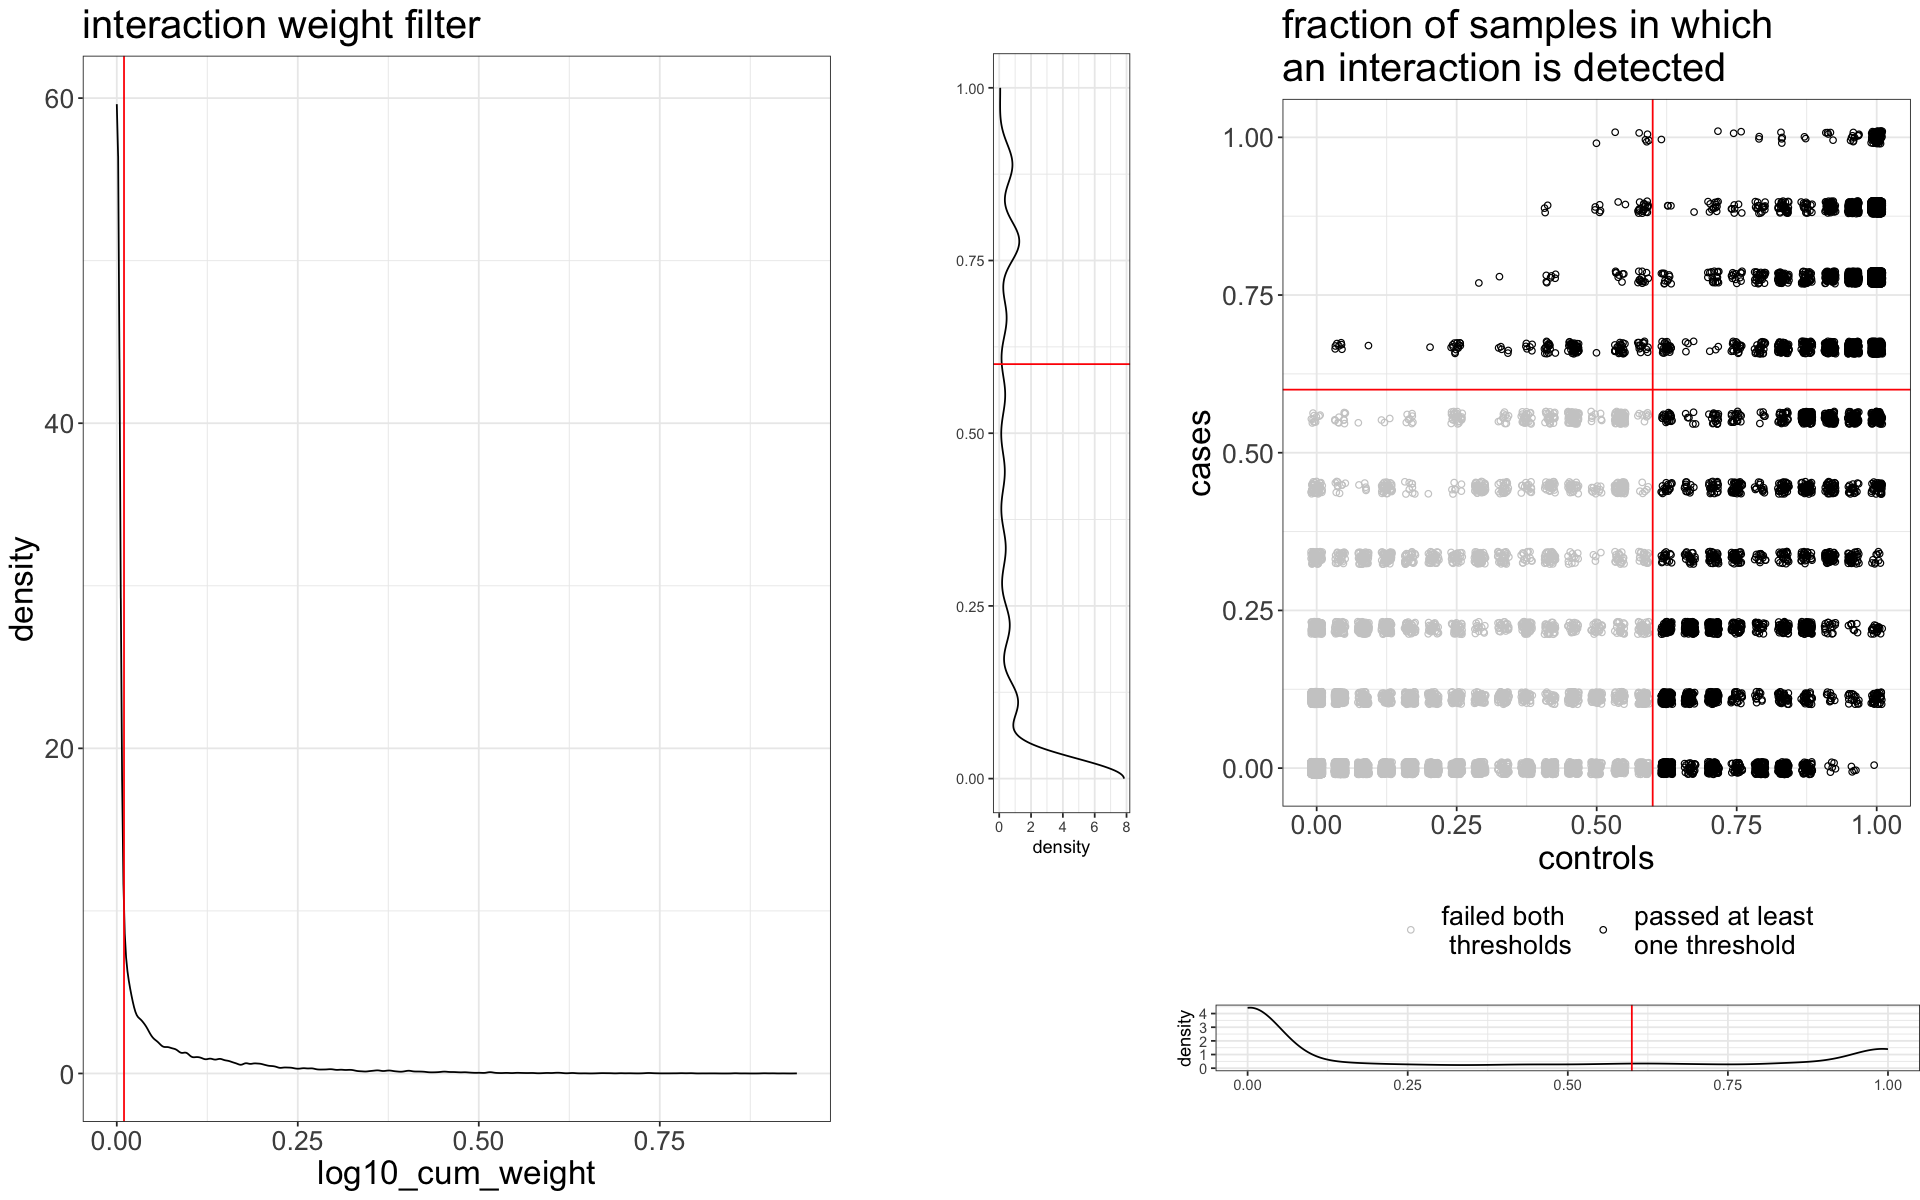

[1] "17823 out of 24408 interactions do not pass the thresholds for log10 cumulative interactions weight > 0.01 and fraction of expressing samples > 0.6 . Also  14981  interactions didn't pass the discrepancy filter.  In total, 17823  bad quality interactions will be removed and 6585 good quality interactions will remain."


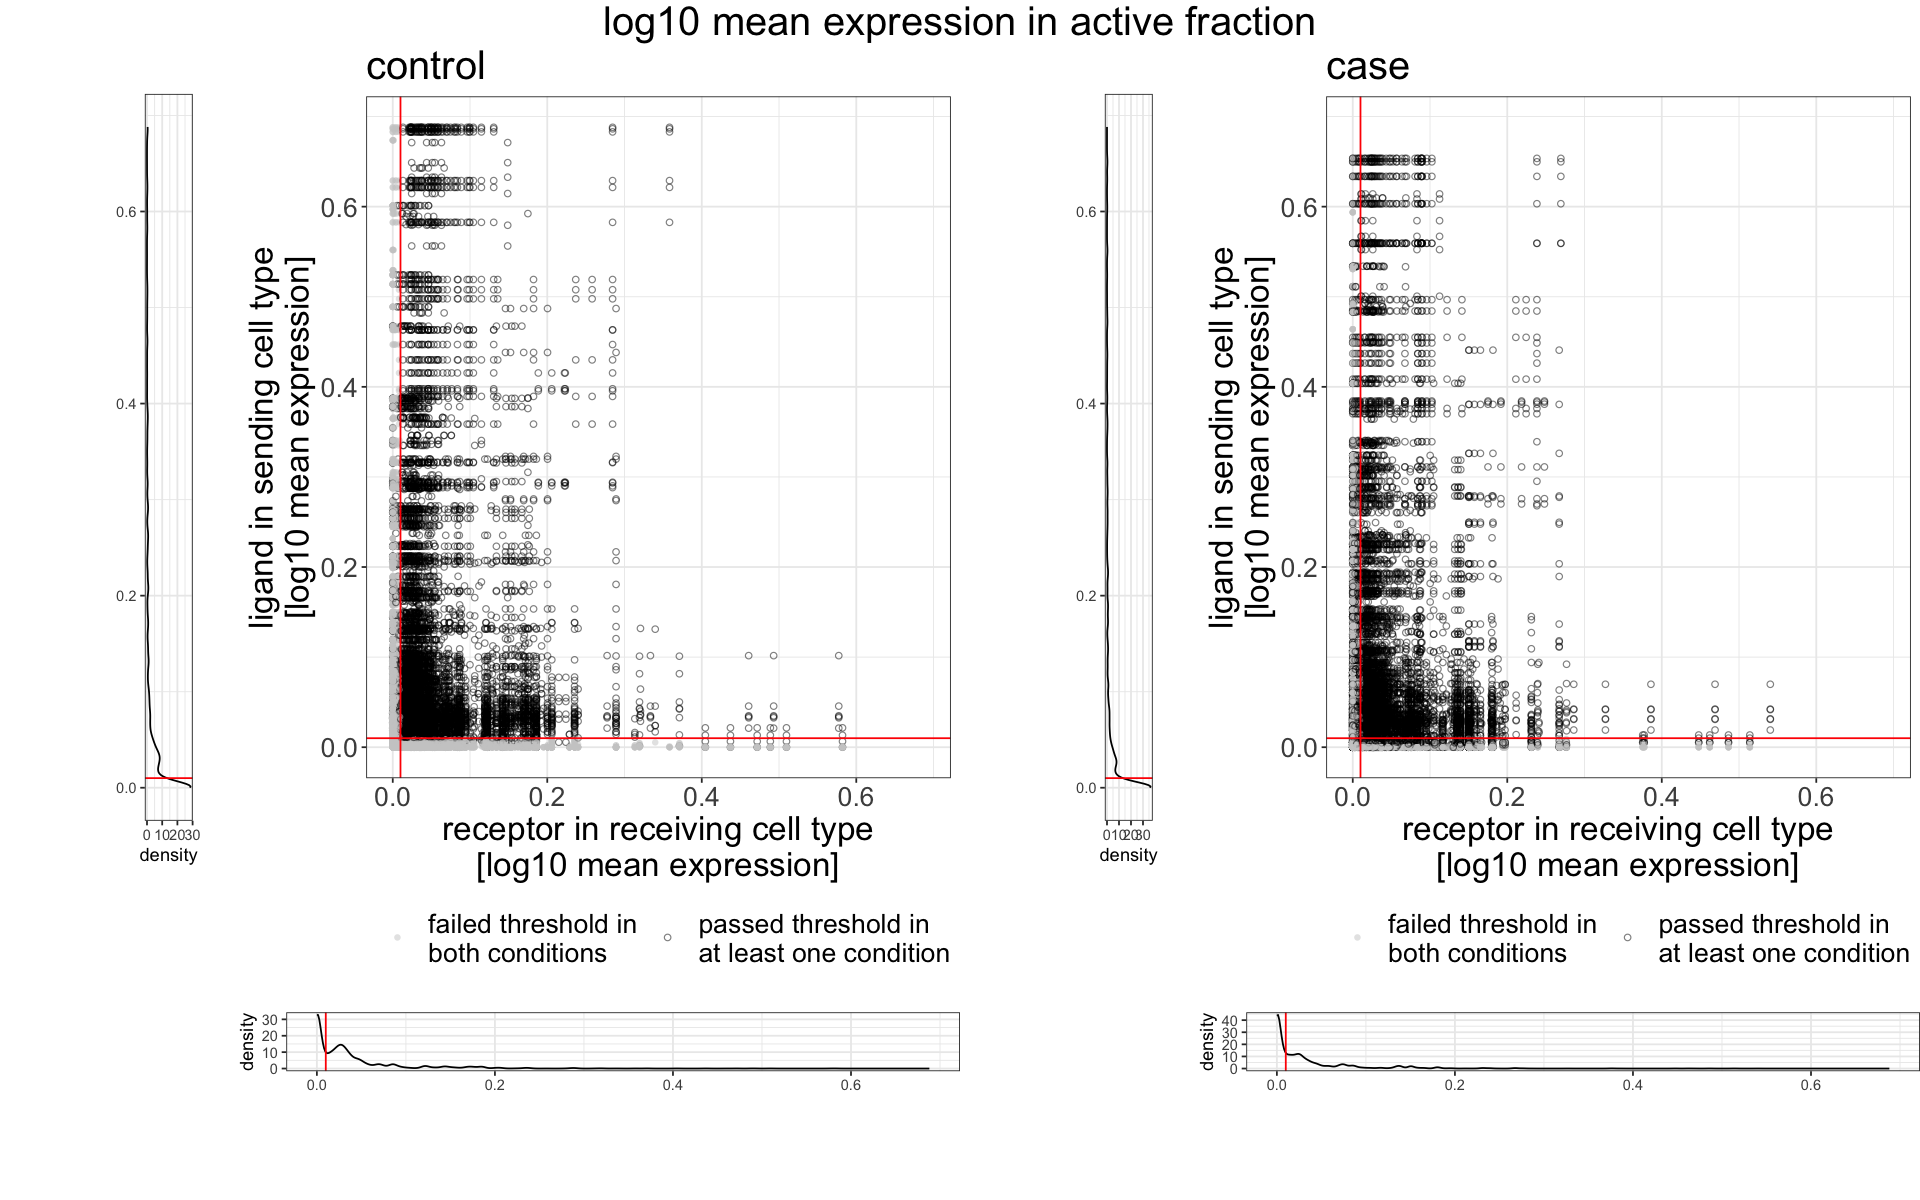

In [18]:
print("filter weak interactions")

options(repr.plot.height = 10
       ,repr.plot.width = 16)
interactions <- filter_interactions(comm_result = interactions
                             ,threshold_frac_samples_per_condition = threshold_frac_samples_per_condition
                             ,threshold_log10_cum_weight = threshold_log10_cum_weight
                             ,threshold_log10_meanexpr_per_condition = threshold_log10_meanexpr_per_condition
)

In [36]:
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

List of 9
 $ threshold_expr                        : num 0.05
 $ threshold_nr_active_cells             : num 0
 $ threshold_celltype_size               : num 4
 $ threshold_log10_cum_weight            : num 0.01
 $ threshold_nr_expr_samples             : num 6
 $ threshold_log10_meanexpr_per_condition: num 0.01
 $ threshold_fdr                         : num 0.1
 $ threshold_log2FC                      : num 1
 $ threshold_frac_samples_per_condition  : num 0.6
NULL
'data.frame':	24408 obs. of  35 variables:
 $ interaction_ID                            : chr  "HSPC:ADAM10_HSPC:AXL" "HSPC:ADAM15_HSPC:ITGA5" "HSPC:ADAM15_HSPC:ITGA9" "HSPC:ADAM15_HSPC:ITGAV" ...
 $ ligand_gene_name                          : chr  "ADAM10" "ADAM15" "ADAM15" "ADAM15" ...
 $ receptor_gene_name                        : chr  "AXL" "ITGA5" "ITGA9" "ITGAV" ...
 $ sending_cell_type                         : chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ receiving_cell_type                       : chr  "HSPC" "HSPC" "HSPC"

# Differential Communication

For calculating statistically significant differential interactions between the cases and the controls, we need to define an adjusted p-value threhsold and the log2 fold change threshold. 

In [37]:
# Set up log2 fold change threshold. The default value is 1
threshold_log2FC <- 1
print(paste("[absolute] threshold_log2FC >",threshold_log2FC))

[1] "[absolute] threshold_log2FC > 1"


In [38]:
# Set up FDR threshold. The default value is 0.1
threshold_fdr <- 0.1
print(paste("threshold_fdr <",threshold_fdr))

[1] "threshold_fdr < 0.1"


The `test_diff` function stores the thresholds in the `thresholds` list of the interactions object.

The `test_diff` function calculates a p-value for each interaction using a Wilcoxon test and adjusts for multiple testing using the FDR correction method. After that, the function checks whether the log2 fold change and the adjusted p-value thresholds were passed. An interactoin is considered significant if it passes both threshodls. The `test_diff` function stores the results as boolean vector to the `anno_interactions` list of the interactions object.

In [39]:
print("calculate differential communication")
interactions <- test_diff(comm_result = interactions
                                ,threshold_fdr = threshold_fdr
                                ,threshold_log2FC = threshold_log2FC
                                )
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

[1] "calculate differential communication"
List of 9
 $ threshold_expr                        : num 0.05
 $ threshold_nr_active_cells             : num 0
 $ threshold_celltype_size               : num 4
 $ threshold_log10_cum_weight            : num 0.01
 $ threshold_nr_expr_samples             : num 6
 $ threshold_log10_meanexpr_per_condition: num 0.01
 $ threshold_fdr                         : num 0.1
 $ threshold_log2FC                      : num 1
 $ threshold_frac_samples_per_condition  : num 0.6
NULL
'data.frame':	24408 obs. of  36 variables:
 $ interaction_ID                            : chr  "HSPC:ADAM10_HSPC:AXL" "HSPC:ADAM15_HSPC:ITGA5" "HSPC:ADAM15_HSPC:ITGA9" "HSPC:ADAM15_HSPC:ITGAV" ...
 $ ligand_gene_name                          : chr  "ADAM10" "ADAM15" "ADAM15" "ADAM15" ...
 $ receptor_gene_name                        : chr  "AXL" "ITGA5" "ITGA9" "ITGAV" ...
 $ sending_cell_type                         : chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ receiving_cell_type       

# Visualisation

In [40]:
idx_up <- interactions$anno_interactions$log2FC_weights >1
idx_unchanged <- abs(interactions$anno_interactions$log2FC_weights)<=1
idx_down <- interactions$anno_interactions$log2FC_weights < -1
idx_sign <- !is.na(interactions$anno_interactions$sign) & interactions$anno_interactions$sign

### Volcano plot

We can now visualize the interactions with a volcano plot. 

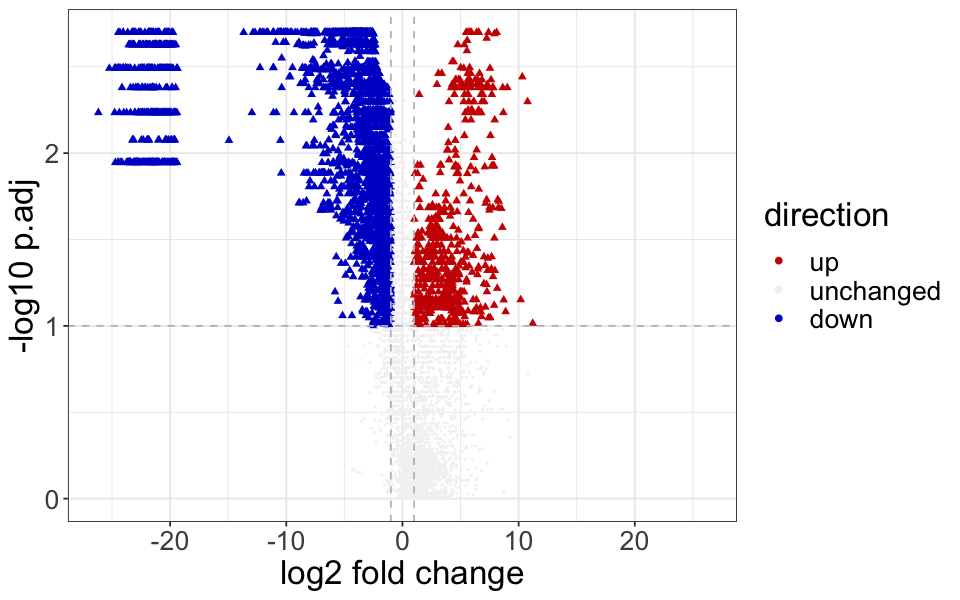

In [41]:
# volcano plot
options(repr.plot.height = 5
       ,repr.plot.width = 8)

idx_good <- interactions$anno_interactions$passed_QC_filter

df <- data.frame(log2FC = interactions$anno_interactions$log2FC_weights[idx_good]
                 ,y = -log10(interactions$anno_interactions$p.adj[idx_good])
                 ,significant = interactions$anno_interactions$sign[idx_good]
                )

df$direction <- "unchanged"
df$direction[df$significant & (df$log2FC > 1)] <- "up"
df$direction[df$significant & (df$log2FC < -1)] <- "down"
df$direction <- factor(df$direction
                      ,levels = c("up"
                                 ,"unchanged"
                                 ,"down")
                      ,ordered = TRUE)

xlab <- "log2 fold change"
ylab <- "-log10 p.adj"

xlim <- c(-max(abs(df$log2FC))
          ,max(abs(df$log2FC))
         )
ylim <- c(0, max(df$y))

p <- ggplot(data = df
            ,aes(x = log2FC
                 ,y = y
                 ,color = direction
                 ,size = significant
                 ,shape = significant
                ))+
geom_point()+
scale_color_manual(values = c("red3"
                               ,"gray95"
                               ,"blue3"))+
scale_size_manual(values = c(0.5, 1.5))+
guides(size = "none"
      ,shape = "none")+
xlab(xlab)+
ylab(ylab)+
xlim( xlim )+
ylim(ylim)+
theme_bw()+
theme(text = element_text(size=20))+
geom_vline(xintercept = interactions$thresholds$threshold_log2FC
          ,lty = 2
          ,color = "gray")+
geom_vline(xintercept = -interactions$thresholds$threshold_log2FC
          ,lty = 2
          ,color = "gray")+
geom_hline(yintercept = -log10(interactions$thresholds$threshold_fdr)
          ,lty = 2
          ,color = "gray")
p




   up unchanged down
1 621      2970 2994


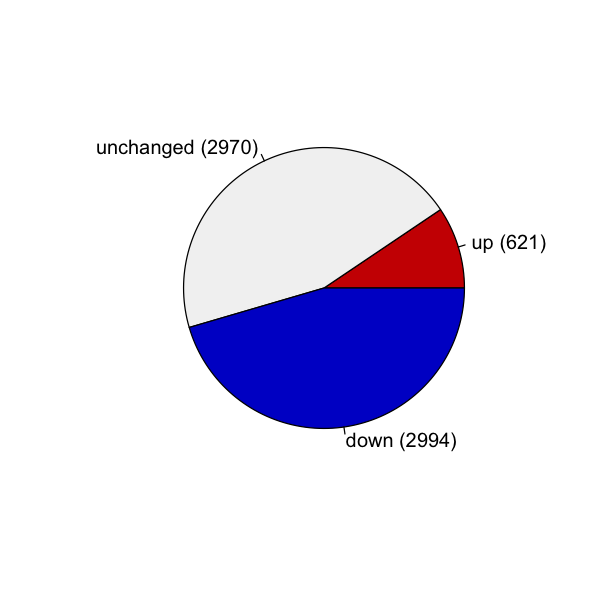

In [42]:
# pie chart
df <- data.frame(up = sum(idx_good & idx_sign & idx_up)
                ,unchanged = sum(idx_good & !idx_sign)
                , down = sum(idx_good & idx_sign & idx_down)
                )
print(df)

options(repr.plot.width = 5
       ,repr.plot.height = 5)
pie(unlist(df)
   ,labels = paste0(colnames(df)," (",unlist(df), ")")
   ,col = c("red3"
           ,"gray95"
           ,"blue3")) 

### Heatmap of top differential interactions

In [25]:
# heatmap of interactions weight of top differential interactions
# top adjusted p value
idx_topsign <- interactions$anno_interactions$p.adj %in% unique(sort(interactions$anno_interactions$p.adj))[1]
# all upregulated interactions
idx_topup <- interactions$anno_interactions$log2FC_weights > 1 & idx_topsign

# top 20 downregulated interactions
idx_topdown <- interactions$anno_interactions$log2FC_weights < -1 & idx_topsign
idx_topdown20 <- interactions$anno_interactions$interaction_ID %in% interactions$anno_interactions$interaction_ID[idx_topdown][1:20]

idx <- idx_topup | idx_topdown20
print(sum(idx))

[1] 32


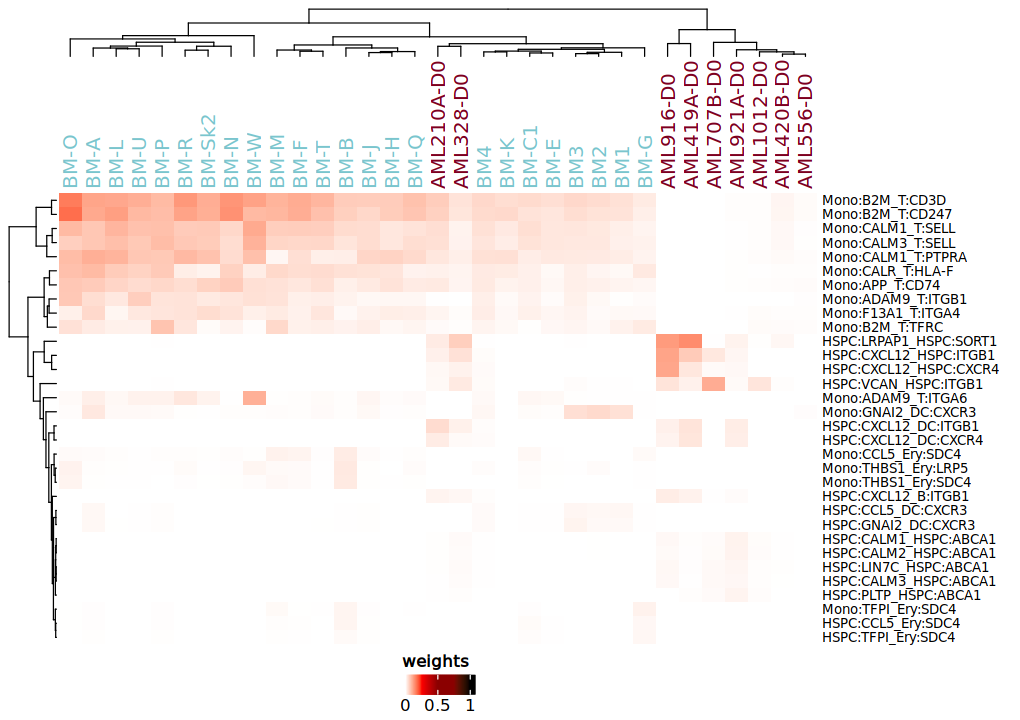

In [26]:
set.seed(1)
options(repr.plot.height = 6
       ,repr.plot.width = 8.5)
plot_heatmap(interactions
            ,which_interactions = idx
            ,values_to_plot = "weights")

#### Individual parameters

In [27]:
cell_types <- unique(interactions$anno_cells$cell_type)
print(cell_types)

[1] "HSPC" "Mono" "DC"   "Ery"  "T"    "B"   


  cell_type log2FC_rho
1      HSPC  3.2165730
3        DC  1.1606928
2      Mono  0.6717878
4       Ery -1.3613534
6         B -1.5796444
5         T -2.7719114


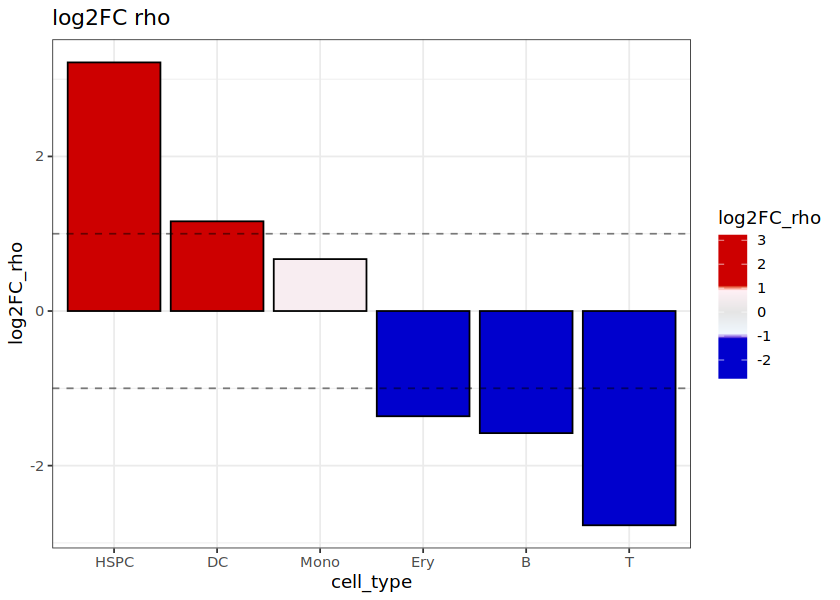

In [28]:
# plot log2FC rho for cell types
df <- data.frame(cell_type = cell_types)
df$log2FC_rho <- sapply(cell_types
                       ,function(ct){
                           idx_ct <- interactions$anno_interactions$sending_cell_type == ct # just take the sending
                         interactions$anno_interactions$log2FC_rho_s[idx_ct][1] # just take the first one
                       })
df <- df[order(df$log2FC_rho,decreasing = TRUE),]
df$cell_type <- factor(df$cell_type
                         ,levels = df$cell_type
                         ,ordered = TRUE)
print(df)

my_values <- c(min(df$log2FC_rho),-1.1,-0.9,0,0.9,1.1,max(df$log2FC_rho))
my_colors <- c("blue3","blue3","aliceblue","gray90","lavenderblush","red3","red3")
names(my_colors) <- my_values
resc_values <- rescale(as.numeric(names(my_colors)))

options(repr.plot.width = 7
       ,repr.plot.height = 5)
ggplot(data = df
      ,aes(x = cell_type
          ,y = log2FC_rho
          ,fill = log2FC_rho)
      )+
geom_col(color = "black")+
scale_fill_gradientn(colours = my_colors
                           ,values = resc_values
                          )+
geom_hline(yintercept = c(-1,1)
          ,lty = 2
          ,lwd = 0.5
          ,alpha = 0.5)+
ggtitle("log2FC rho")+
theme_bw()

'data.frame':	24392 obs. of  2 variables:
 $ cell_type: Ord.factor w/ 6 levels "HSPC"<"DC"<"Mono"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ log2FC   : Ord.factor w/ 3 levels "log2FC > 1"<"unchanged"<..: 1 1 1 1 1 1 1 1 1 1 ...
NULL


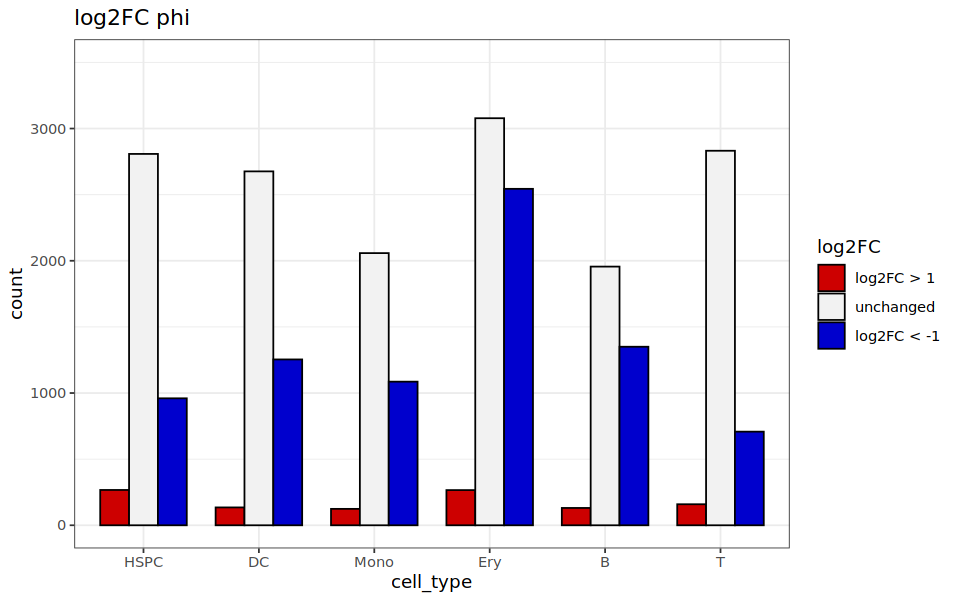

In [29]:
# phi log2FC by cell type
df <- lapply(c("up"
                    ,"unchanged"
                    ,"down")
                   ,function(dir){
                       if(dir == "up"){
                           idx_send <-interactions$anno_interactions$log2FC_phi_s_l > 1 & idx_good
                           idx_rec <- interactions$anno_interactions$log2FC_phi_r_r > 1 & idx_good
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }else if(dir == "down"){
                           idx_send <-interactions$anno_interactions$log2FC_phi_s_l < -1 
                           idx_rec <- interactions$anno_interactions$log2FC_phi_r_r < -1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       } else {
                           idx_send <- abs(interactions$anno_interactions$log2FC_phi_s_l) > 1 
                           idx_rec <- abs(interactions$anno_interactions$log2FC_phi_r_r) > 1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }
                       
                   }
                       )
df <- rbind(df[[1]],df[[2]],df[[3]])
df$cell_type <- factor(df$cell_type
                         ,levels = c("HSPC"
                                     ,"DC"
                                    ,"Mono"
                                    ,"Ery"
                                    ,"B"
                                    ,"T")
                         ,ordered = TRUE)
df$log2FC <- factor(df$log2FC
                      ,levels = c("up"
                                 ,"unchanged"
                                 ,"down")
                       ,labels = c("log2FC > 1"
                                  ,"unchanged"
                                  ,"log2FC < -1")
                      ,ordered = TRUE)
print(str(df))

           
options(repr.plot.width = 8
       ,repr.plot.height = 5)
p <- ggplot(data = df
          ,aes(x = cell_type
               ,fill = log2FC
              )
           )+
    geom_bar(position = "dodge"
            ,width=.75
            ,color = "black")+
scale_fill_manual(values = c("red3","gray95","blue3"))+
    ggtitle("log2FC phi")+
    ylim(c(0,3500))+
    theme_bw()

p

'data.frame':	21995 obs. of  2 variables:
 $ cell_type: Ord.factor w/ 6 levels "HSPC"<"DC"<"Mono"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ log2FC   : Ord.factor w/ 3 levels "log2FC > 1"<"unchanged"<..: 1 1 1 1 1 1 1 1 1 1 ...
NULL


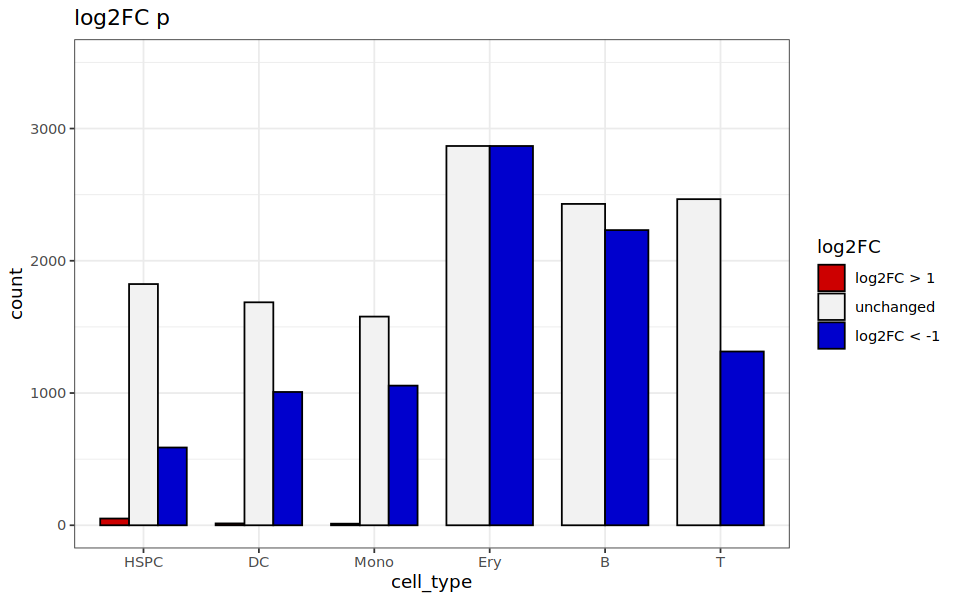

In [30]:
# phi log2FC by cell type
df <- lapply(c("up"
                    ,"unchanged"
                    ,"down")
                   ,function(dir){
                       if(dir == "up"){
                           idx_send <-interactions$anno_interactions$log2FC_p_s_l > 1 & idx_good
                           idx_rec <- interactions$anno_interactions$log2FC_p_r_r > 1 & idx_good
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }else if(dir == "down"){
                           idx_send <-interactions$anno_interactions$log2FC_p_s_l < -1 
                           idx_rec <- interactions$anno_interactions$log2FC_p_r_r < -1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       } else {
                           idx_send <- abs(interactions$anno_interactions$log2FC_p_s_l) > 1 
                           idx_rec <- abs(interactions$anno_interactions$log2FC_p_r_r) > 1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }
                       
                   }
                       )
df <- rbind(df[[1]],df[[2]],df[[3]])
df$cell_type <- factor(df$cell_type
                         ,levels = c("HSPC"
                                     ,"DC"
                                    ,"Mono"
                                    ,"Ery"
                                    ,"B"
                                    ,"T")
                         ,ordered = TRUE)
df$log2FC <- factor(df$log2FC
                      ,levels = c("up"
                                 ,"unchanged"
                                 ,"down")
                    ,labels = c("log2FC > 1"
                               ,"unchanged"
                               ,"log2FC < -1")
                      ,ordered = TRUE)
print(str(df))

           
options(repr.plot.width = 8
       ,repr.plot.height = 5)
p <- ggplot(data = df
          ,aes(x = cell_type
               ,fill = log2FC
              )
           )+
    geom_bar(position = "dodge"
            ,width=.75
            ,color = "black")+
scale_fill_manual(values = c("red3","gray95","blue3"))+
    ggtitle("log2FC p")+
    ylim(c(0,3500))+
    theme_bw()

p

### Classes of interactions

In this section, we will check which of the individual components (rho, phi, p) are driving the change of the interactions. For this, we will combine following forest plots: 
- log2 fold change of the interaction weight (`w`)
- log2 fold change of the cell type abundance of the sending cell type (`rho_s`)
- log2 fold change of the active fraction of the sending cell type expressing the ligand (`phi_s_l`)
- log2 fold change of the expression of the sending cell type expressing the ligand (`p_s_l`)
- log2 fold change of the cell type abundance of the receiving cell type (`rho_r`)
- log2 fold change of the active fraction of the receiving cell type expressing the receptor (`phi_r_r`)
- log2 fold change of the expression of the receiving cell type expressing the receptor (`p_r_r`)

We will first explore the interaction that were unchanged. We will start with the interactions that had a trully unchanged log2 fold change of the weight (i.e. -1 < `log2FC_weight` < 1), and then plot the interactions with eigther up- or down-regulated log2 fold change of the weight, which though didn't pass the adjusted p-value threshold.

#### Unchanged

In [31]:
idx_of_interest <- !idx_sign & idx_good
sum(idx_of_interest)

[1] 3450

 No log2FC of the w.

In [32]:
idx_w <- abs(interactions$anno_interactions$log2FC_weights) < 1
sum(idx_of_interest & idx_w)

[1] 1452

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "8 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "299 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "601 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "7 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "4 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "5 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "1 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "1 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "50 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "101 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "39 interac

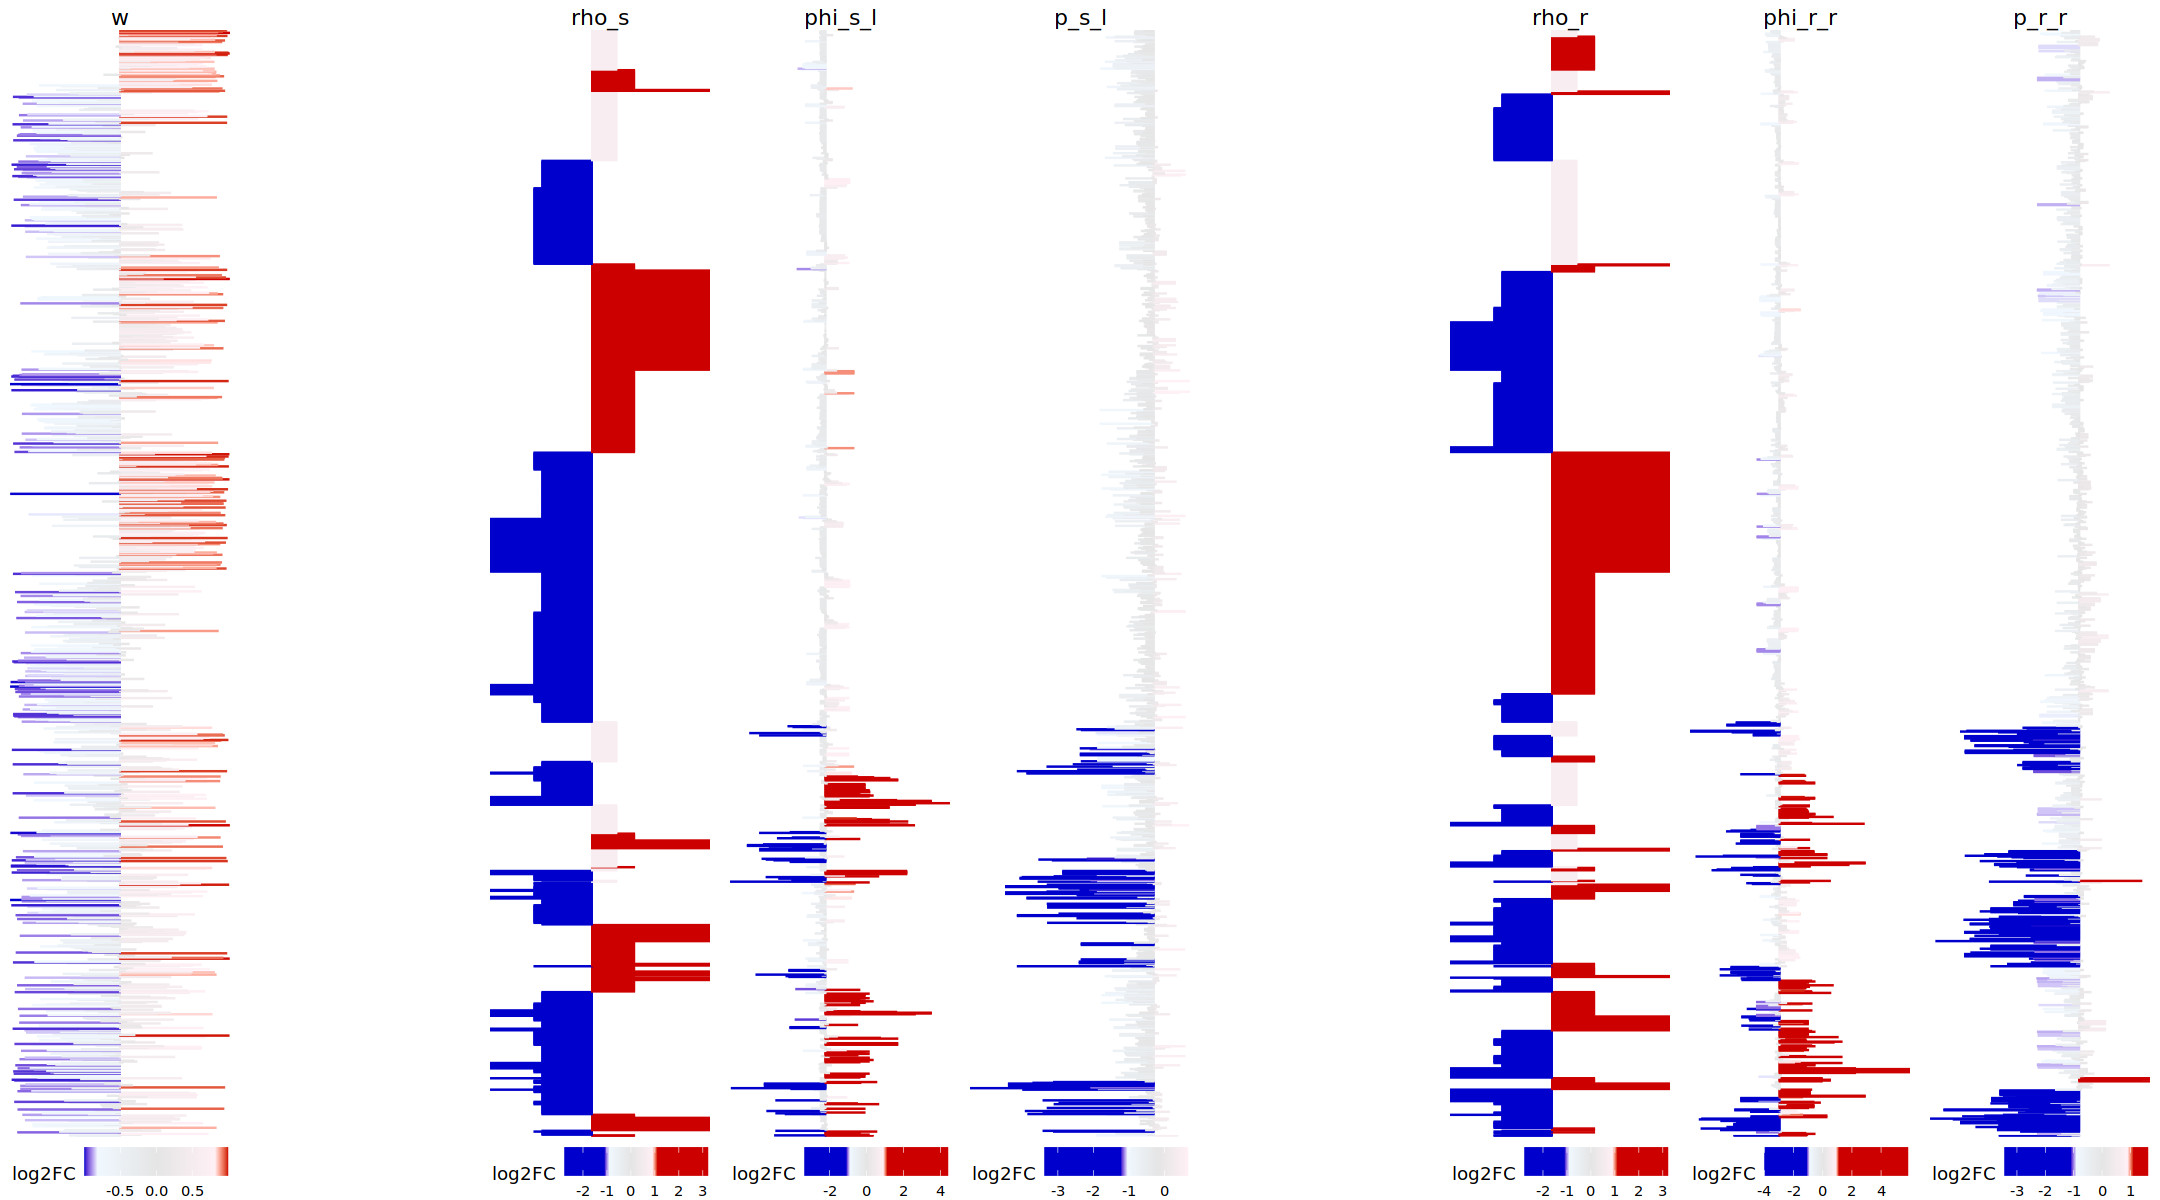

In [33]:
options(repr.plot.height = 10
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest & idx_w
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>

ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

Log2FC of w > 1, but is not significant.

In [34]:
idx_w <- interactions$anno_interactions$log2FC_weights > 1
sum(idx_of_interest & idx_w)

[1] 1716

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "148 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "356 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "610 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "30 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "1 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "12 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "7 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "1 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "1 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "32 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "117 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "7 inte

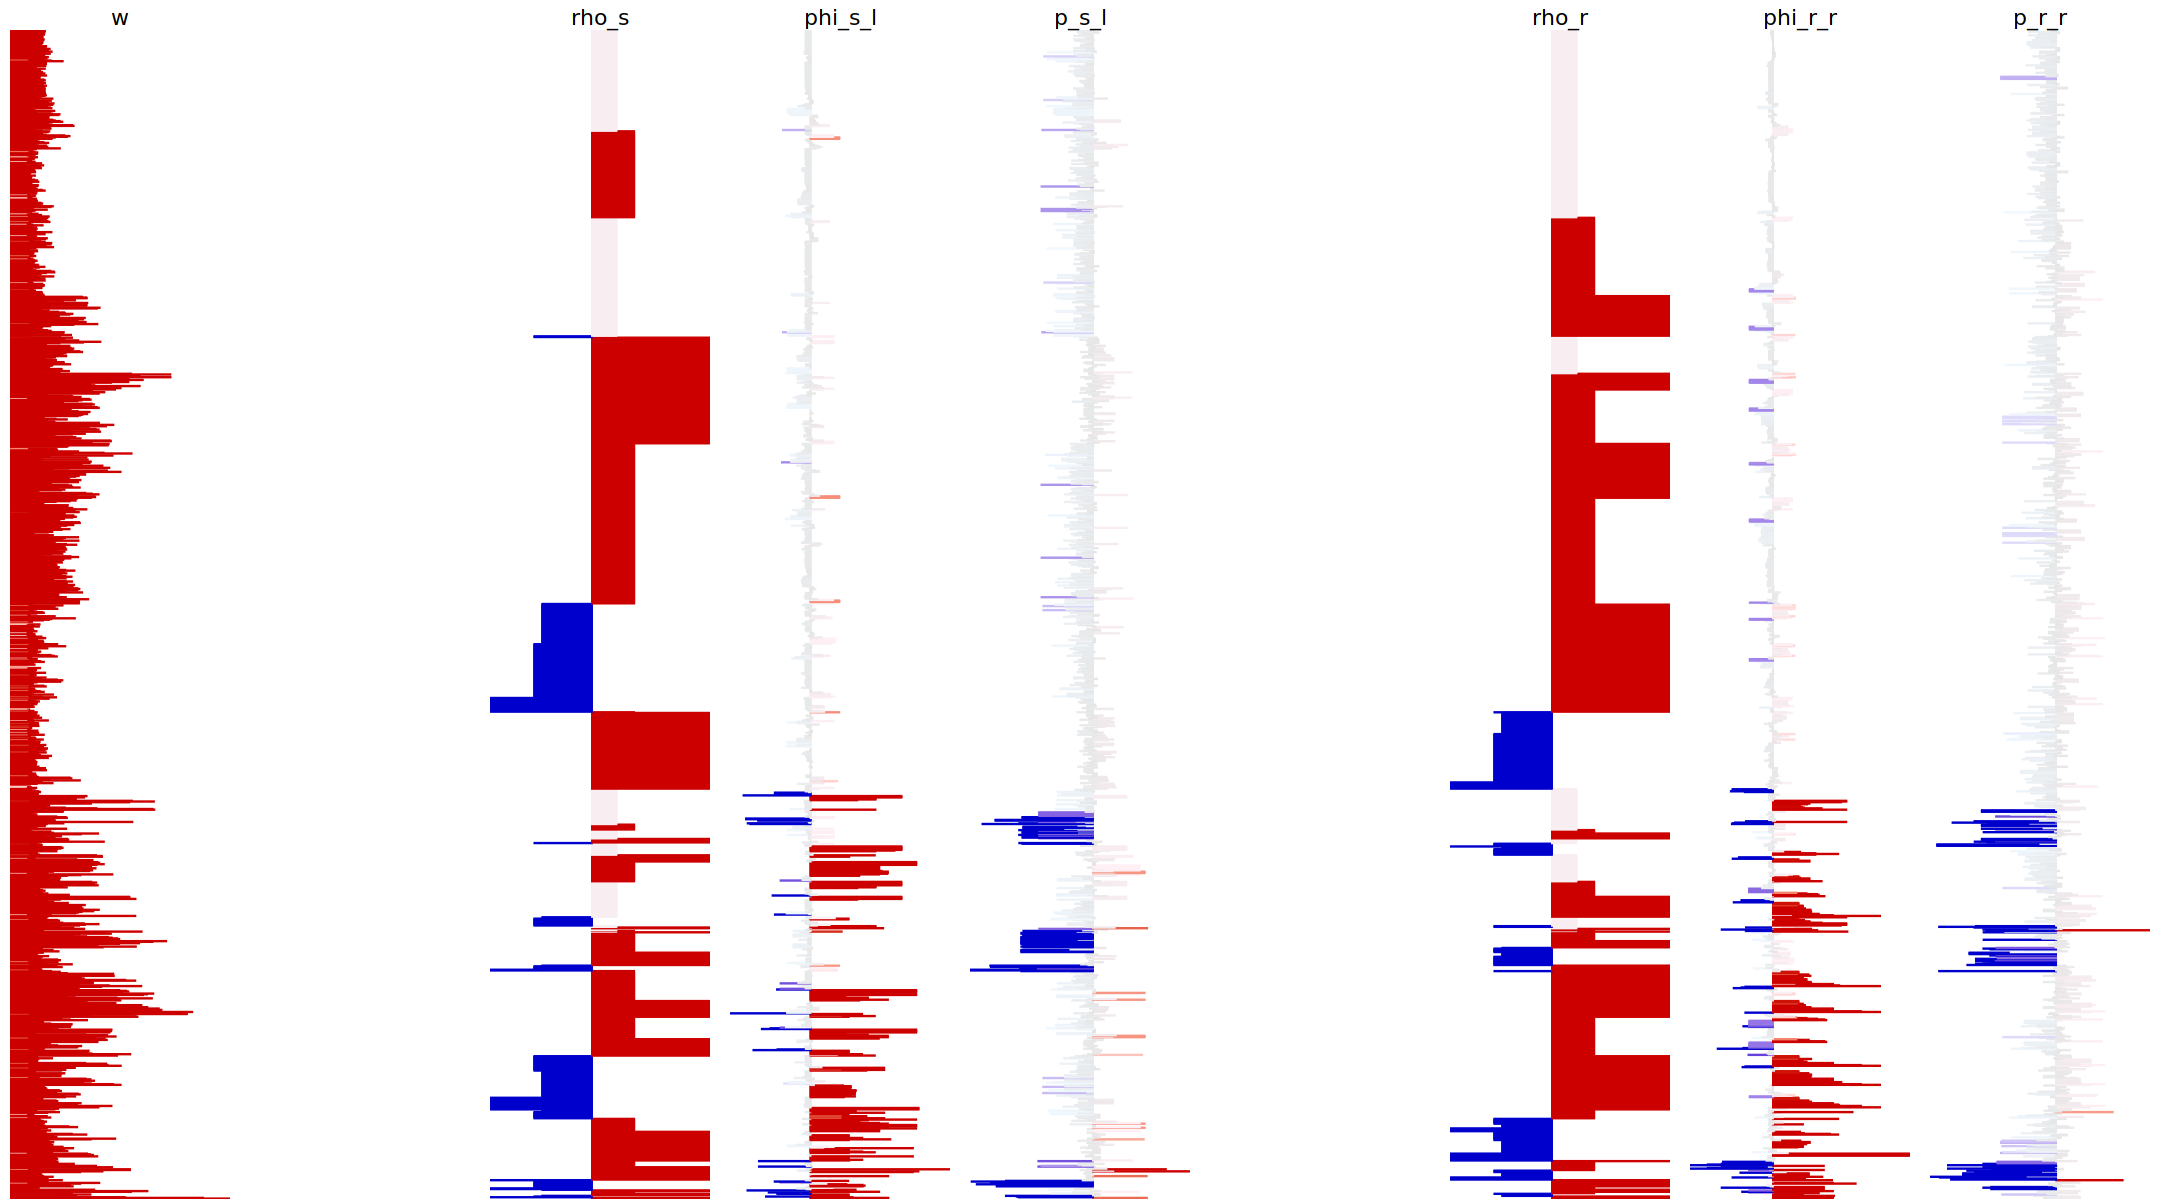

In [35]:
options(repr.plot.height = 10
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest & idx_w
                ,my_anno_interactions = interactions$anno_interactions, plot_legend=FALSE)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>

ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

Log2FC of w < -1, but is not significant.

In [36]:
idx_w <- interactions$anno_interactions$log2FC_weights < -1
sum(idx_of_interest & idx_w)

[1] 282

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "51 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "43 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "2 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "15 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "1 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "19 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "22 interactio

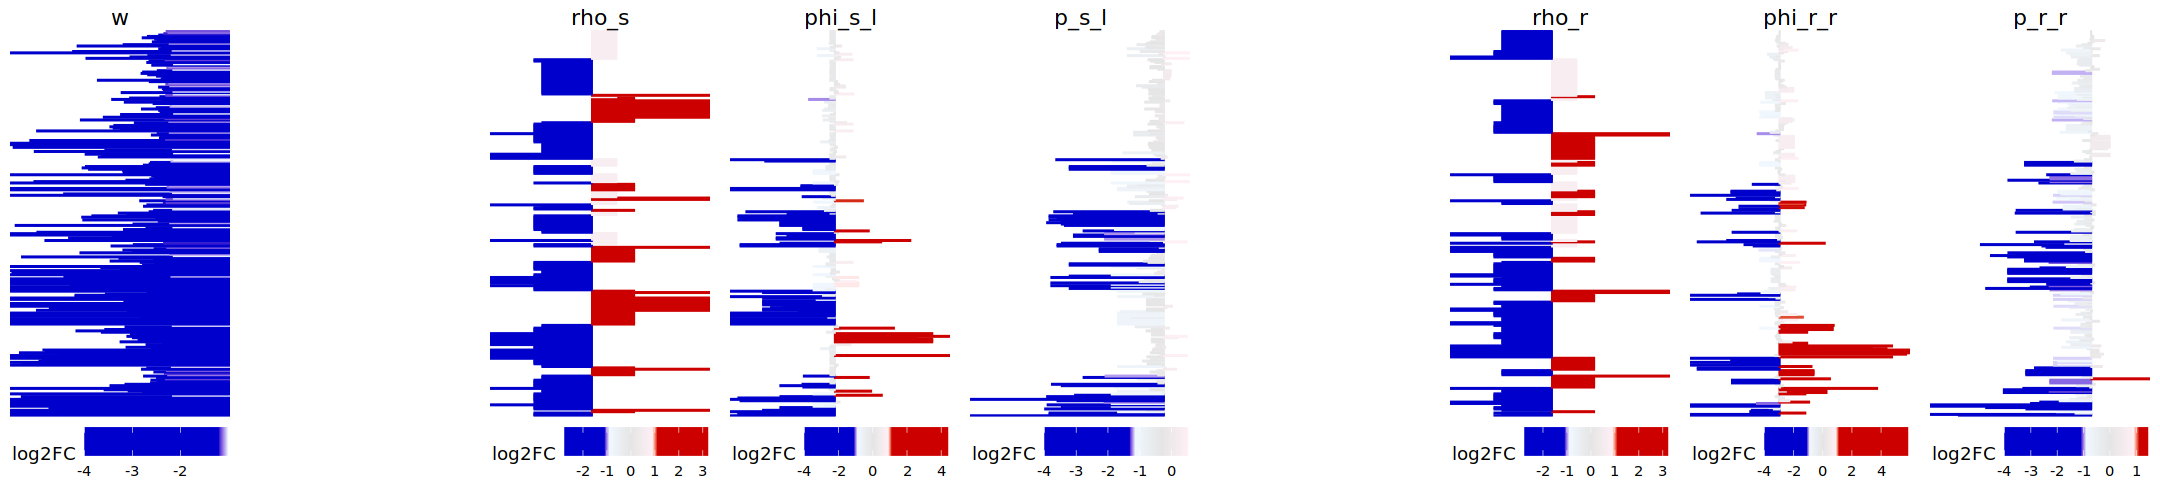

In [37]:
options(repr.plot.height = 4
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest & idx_w
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>


ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

#### Up-regulated

Now we will explore the interactions in which the `log2FC_weights` passed the upper log2 fold change threshodl, but didn't pass the adjusted p-value threshold.

In [38]:
idx_of_interest <- idx_good & idx_sign & idx_up
sum(idx_of_interest)

[1] 658

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "178 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "273 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "3 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "6 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "36 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "2 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "21 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "20 interact

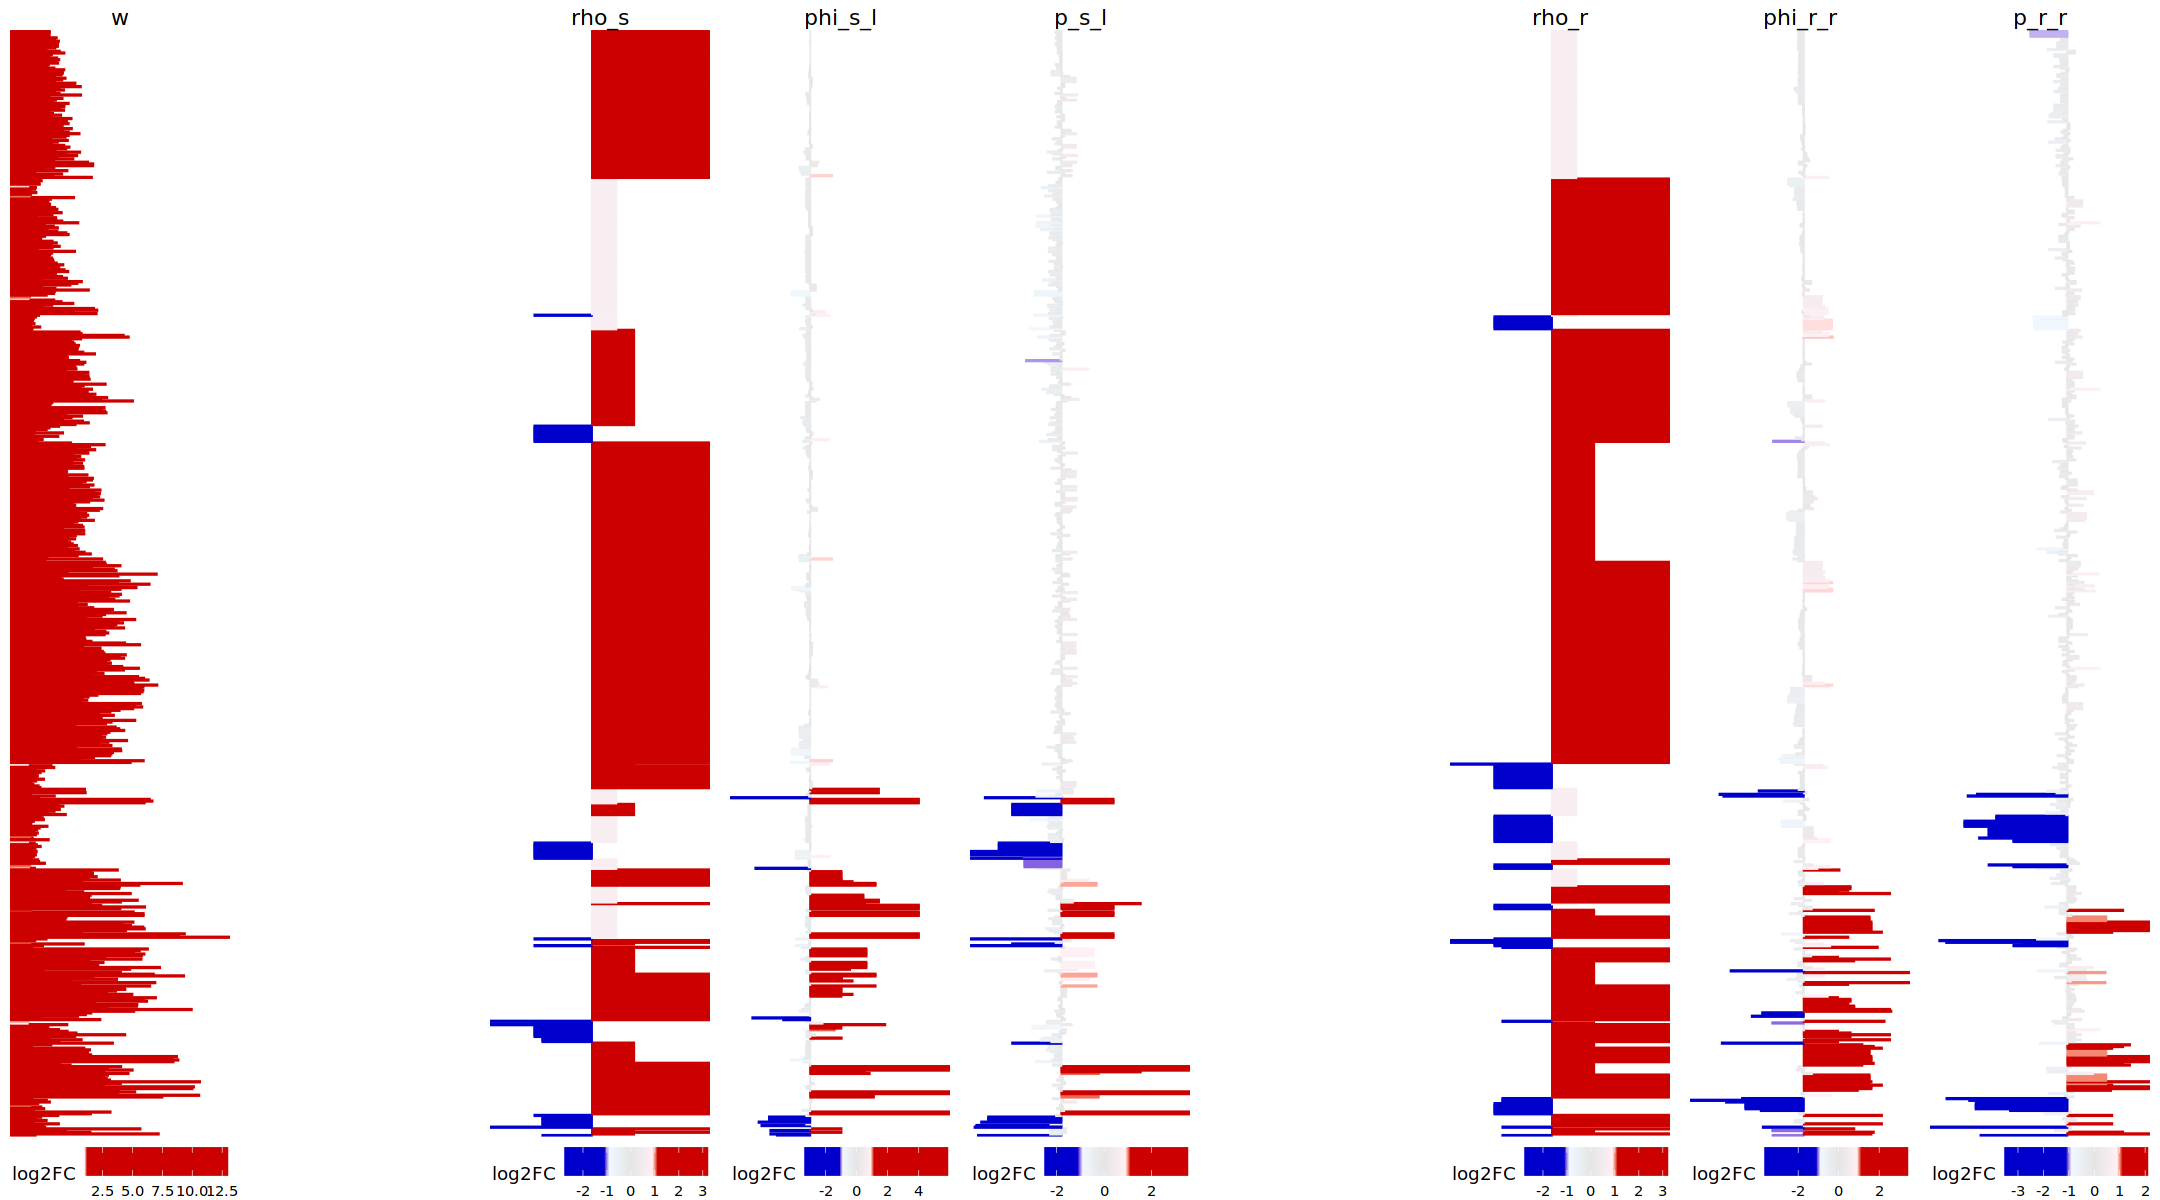

In [39]:
options(repr.plot.height = 10
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>


ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

#### Down-regulated

Here we will explore the interactions in which the `log2FC_weights` passed the lower log2 fold change threshodl, but didn't pass the adjusted p-value threshold.

In [40]:
idx_of_interest <- idx_good & idx_sign & idx_down
sum(idx_of_interest)

[1] 3480

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "381 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "1024 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "18 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "65 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "3 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "56 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "316 inter

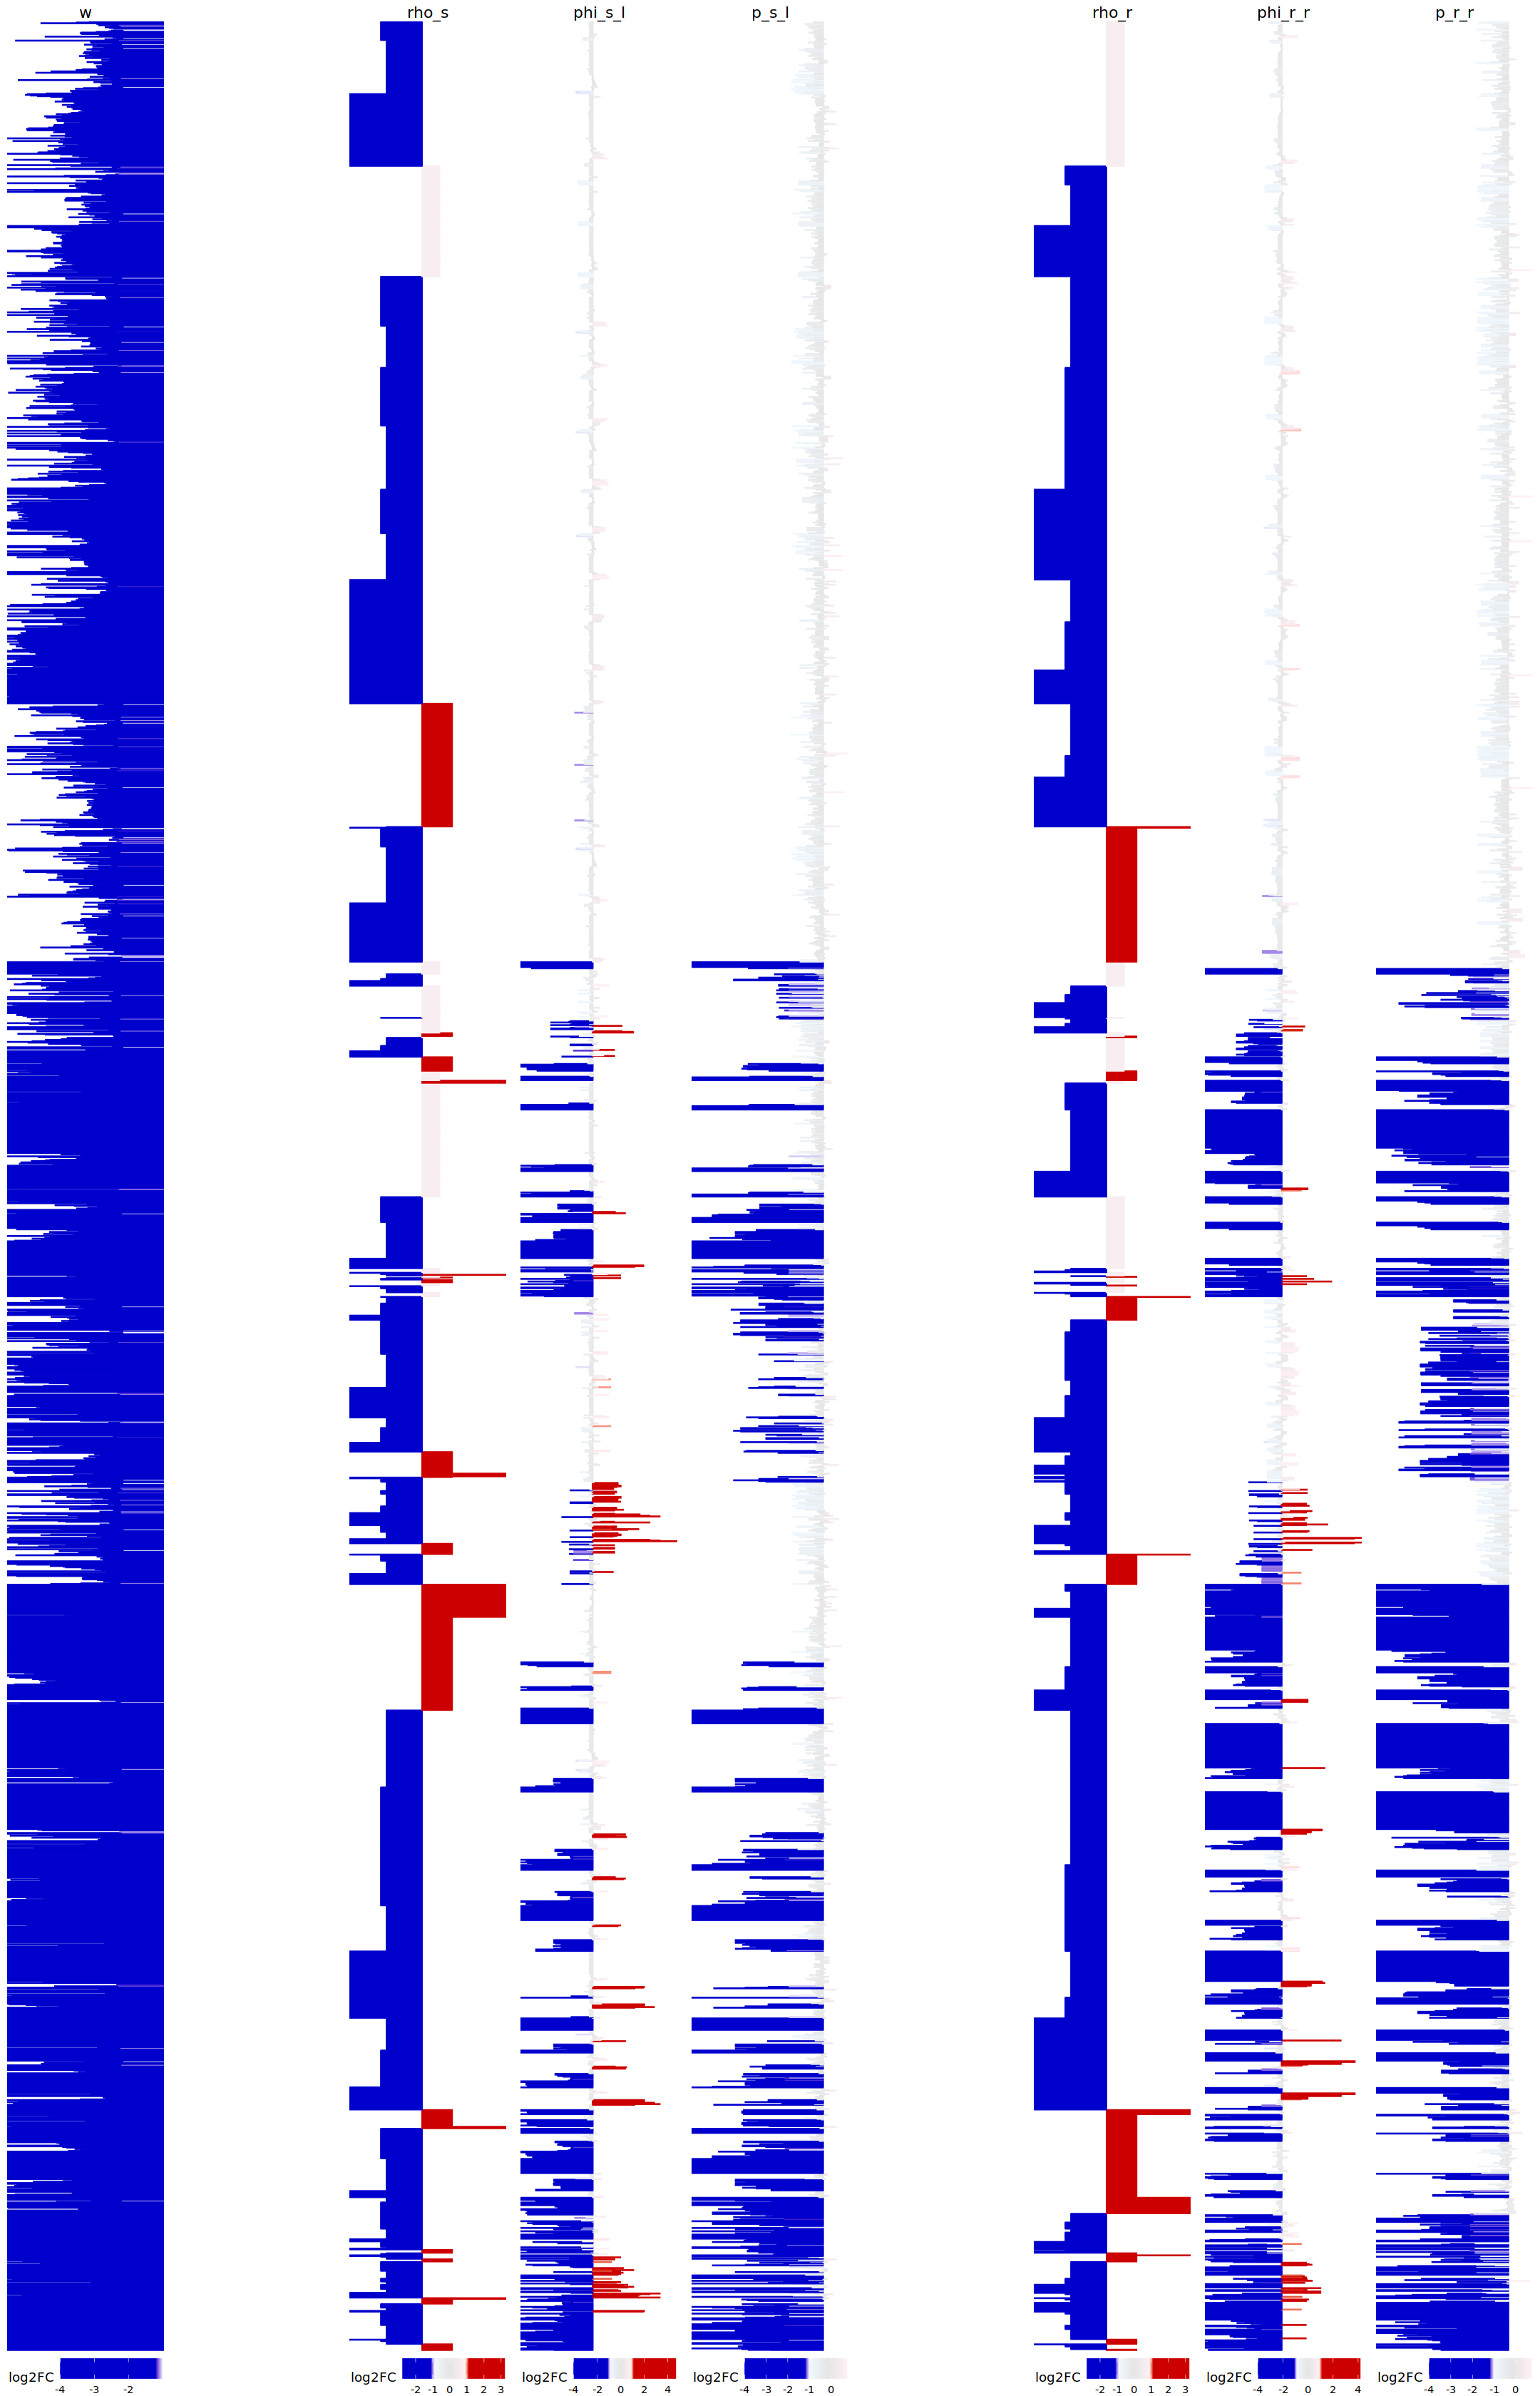

In [41]:
options(repr.plot.height = 28
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>


ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

### Graphs for each cell type

In this section, we will explore the up- and down-regulated interactions for each cell type. We will take the significantly differential interactions and plot the graphs of up- and down-regulated interactions per cell type, with nodes being cell types and the interactions being mean `log2FC_weigt` of the interactions connecting two corresponding cell types. We will also plot the forest plots for the up- and down-regulated interactions of each cell type.

In [42]:
dir.create("figures")

for(cell_type in unique(interactions$anno_cells$cell_type)
   ){
    for(dir in c("down"
                ,"up")
       ){
        # idx of the interactions
        idx_cell_type <- (interactions$anno_interactions$sending_cell_type == cell_type) | (interactions$anno_interactions$receiving_cell_type == cell_type)
        
        ifelse(dir == "up"
              ,idx <- idx_cell_type & idx_good & idx_sign & idx_up
              ,idx <- idx_cell_type & idx_good & idx_sign & idx_down
              )
        
        print(cell_type)
        print(dir)
        print(sum(idx))
        
        # export
        pdf(paste0("./figures"
                  ,"/"
                   ,cell_type
                   ,"_"
                   ,dir
                   ,"_meanLog2FC_graph.pdf"
                  )
            ,width = 8
            ,height = 8
           )
        plot_mean_log2FCw_graph(interactions,idx,dir)
        dev.off()
        
        ifelse(sum(idx)< 10
               ,my_height <- 2
               ,ifelse(sum(idx)< 500
                 ,my_height <- 5
                 ,ifelse(sum(idx)< 1000
                        ,my_height <- 10
                        ,ifelse(sum(idx)< 2000
                                ,my_height <- 15
                               ,my_height <- 20))
                 )
              )
        
        
        pdf(paste0("./figures"
                  ,"/"
                   ,cell_type
                   ,"_"
                   ,dir
                   ,"_forest.pdf"
                  )
            ,width = 10
            ,height = my_height
           )
        # plot forest
        plot_all_forests(idx,my_anno_interactions = interactions$anno_interactions)
        
        dev.off()
    }
}

Warning message in dir.create("figures"):
“'figures' already exists”


[1] "HSPC"
[1] "down"
[1] 100
[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "0 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "2 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "0 interactions"
[1] "rho" "one" "phi" "one" "p" 

# Export

In [43]:
print("save interactions.RData")
save(interactions, file = "interactions.RData")

[1] "save interactions.RData"
